### import modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import mnist
import pylab
import copy

sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### define functions for code

In [56]:

# data loading function
def load_dataset():
    mndata = mnist.MNIST('./python-mnist/data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    
    labels_train = labels_train.astype('int')
    labels_test = labels_test.astype('int')
    return X_train, X_test,labels_train,labels_test

def convert_2_7(x_train,x_test,labels_train,labels_test):
    #import pdb; pdb.set_trace()
    mask_train = np.logical_or(labels_train==2,labels_train==7)
    mask_test = np.logical_or(labels_test==2,labels_test==7)
   # mask_train = labels_train==2 or labels_train==7
    #mask_test = labels_test==2 or labels_test==7
    
    x_train_c = x_train[mask_train]
    x_test_c = x_test[mask_test]
    

    labels_train_c = labels_train[mask_train]
    labels_test_c = labels_test[mask_test]
    
    labels_train_c[labels_train_c==2] = -1
    labels_train_c[labels_train_c==7] = 1

    labels_test_c[labels_test_c==2] = -1
    labels_test_c[labels_test_c==7] = 1

    return x_train_c,x_test_c,labels_train_c,labels_test_c 

def gradient_method(X,y,X_test,y_test,lambda_val):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 0
    #step_size = 1e-3
    step_size = 3e-2
    criteria_conv = 0.000004

    w = np.zeros((np.shape(X)[1],))
    b = 0

    n = np.shape(X)[0]
    n_features = np.shape(X)[1]
    n_test = np.shape(X_test)[0]
    
    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))     
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    print('the value of j train is {}'.format(j_train))

    ####### testing part
    cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

    j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)

    ###       
    w_vec.append(w)
    b_vec.append(b)

    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]

    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n_test

    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    w_old = copy.copy(w)
    b_old = copy.copy(b)
    
    while not_conv:
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 

        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/n)*np.sum(-y*(1-mu_vec))

        # 
        w = w_old - step_size*g_w
        b = b_old - step_size*g_b

        w_vec.append(w)
        b_vec.append(b)
        
        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))
        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        ####### testing part

        mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
        cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        #### classificaiton
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)
        
        
        delta_w = np.abs(w-w_old)
        delta_b = np.abs(b-b_old)
        
        #w = np.array(w)
        w_old = copy.copy(w)
        b_old = copy.copy(b)


        # check convergence
        if ((1/n_features)*np.sum(delta_w))<criteria_conv and k>1:
            not_conv = False

        else:
            not_conv = True
            k += 1

        print('the value of j train is {}'.format(j_train))

        #print('the value of delta_w is {}'.format(delta_w))
        #print(mu_vec)
        #print(not_conv)

    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec

def SGD(X,y,X_test,y_test,lambda_val,batch_size):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 0
    #step_size = 1e-3
    step_size = 5e-2
    criteria_conv = 0.004

    w = np.zeros((np.shape(X)[1],))
    b = 0
    
    ##### gradient descent batch size choice
    batch_range =np.arange(np.shape(X)[0])


    n = np.shape(X)[0]
    n_features = np.shape(X)[1]
    n_test = np.shape(X_test)[0]
    
    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))     
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    print('the value of j train is {}'.format(j_train))

    ####### testing part
    cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

    j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)


    ###       
    w_vec.append(w)
    b_vec.append(b)

    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]

    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n_test

    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    w_old = copy.copy(w)
    b_old = copy.copy(b)

    while not_conv:
        # stochastic choice
        np.random.shuffle(batch_range)
        inds_choose = np.random.choice(batch_range,size=batch_size,replace=False)
        X_sub = X[inds_choose,:]
        y_sub = y[inds_choose]
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y_sub.T*(b+np.dot(X_sub,w)))) 

        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/batch_size)*(np.dot(X_sub.T,(-y_sub*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/batch_size)*np.sum(-y_sub*(1-mu_vec))
        
        # 
        w = w_old - step_size*g_w
        b = b_old - step_size*g_b

        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))
        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        print('the value of j train is {}'.format(j_train))

        ####### testing part

        mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
        cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

        w_vec.append(w)
        b_vec.append(b)

        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        #### classificaiton
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)

        delta_w = np.abs(w-w_old)
        delta_b = np.abs(b-b_old)

        #w = np.array(w)
        w_old = copy.copy(w)
        b_old = copy.copy(b)
        # check convergence
       # if ((1/n_features)*np.sum(delta_w))<criteria_conv and k>1:
        if k>1000:
            not_conv = False

        else:
            not_conv = True
            k += 1
            
    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec

def newton_method(X,y,X_test,y_test,lambda_val):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 1
    #step_size = 1e-3
    step_size = 1
    criteria_conv = 0.004

    w = np.zeros((np.shape(X)[1],))
    b = 0

    n = np.shape(X)[0]
    n_features = np.shape(X)[1]
    n_test = np.shape(X_test)[0]
    #mu_vec = np.zeros((np.shape(X)[0],))
    #cost_mu = np.zeros((np.shape(X)[0],))
    #range_vec = np.arange(len(mu_vec))

    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))     
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    print('the value of j train is {}'.format(j_train))

    ####### testing part
    cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

    j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)


    ###       
    w_vec.append(w)
    b_vec.append(b)

    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]

    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n_test

    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    w_old = copy.copy(w)
    b_old = copy.copy(b)

    while not_conv:
 
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w))))
        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/n)*np.sum(-y*(1-mu_vec))
        
        s_vec = mu_vec*(1-mu_vec)
        diag_sigmoid = np.diag(s_vec)
        identity_lambda = np.identity(np.shape(X)[1])
        h_w = (1/n)*np.dot(X.T,np.dot(diag_sigmoid,X)) + lambda_val*identity_lambda
        h_b = np.sum((1/n)*s_vec)
        
        d_k_w = np.linalg.solve(h_w,-g_w)
        #d_k_b = np.linalg.solve(h_b,-g_b)
        d_k_b = -g_b/h_b

        # 
        w = w_old + step_size*d_k_w
        b = b_old + step_size*d_k_b
        
        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))     

        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        ####### testing part
        cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)
                             
        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        
        ###       
        w_vec.append(w)
        b_vec.append(b)
        
        #### classificaiton
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)
        
        print('the value of j train is {}'.format(j_train))
        
        delta_w = np.abs(w-w_old)
        delta_b = np.abs(b-b_old)
        
        #w = np.array(w)
        w_old = copy.copy(w)
        b_old = copy.copy(b)
        
        print((1/n_features)*np.sum(delta_w))
                            
        # check convergence
        if ((1/n_features)*np.sum(delta_w))<criteria_conv and k>1:
            not_conv = False

        else:
            not_conv = True
            k += 1

    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec


def plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,titl_1):
    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(k_vec,j_train_vec,label='training')
    plt.plot(k_vec,j_test_vec,label='testing')
    plt.xlabel('iteration number')
    plt.ylabel('cost function')
    plt.title(titl_1 + 'Cost function vs. iteration')
    plt.legend()
    index = np.argmin(j_train_vec)
    k_best = k_vec[index]
    w_best = w_vec[index]
    plt.savefig(titl_1[:-2] + 'cost_func')

    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(k_vec,train_classify_vec,label='training data')
    plt.plot(k_vec,test_classify_vec,label='test data')
    plt.xlabel('iteration number')
    plt.ylabel('misclassification error')
    plt.title(titl_1 + 'Misclassification error vs. iteration number')
    plt.legend()
    plt.savefig(titl_1[:-2] + 'mis_class_error')


### Load and convert data 

In [3]:
x_train,x_test,labels_train,labels_test = load_dataset()

In [4]:
x_train_c,x_test_c,labels_train_c,labels_test_c  = convert_2_7(x_train,x_test,labels_train,labels_test)

In [5]:
lambda_val = 10**-1

### perform processing 

In [57]:
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = gradient_method(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val)

the value of j train is 0.6931471805599452
the value of j train is 0.6419470646866495
the value of j train is 0.598117300684645
the value of j train is 0.5604211947512611
the value of j train is 0.5278547997873291
the value of j train is 0.49959429616248746
the value of j train is 0.4749599174213264
the value of j train is 0.45338942576567126
the value of j train is 0.4344172147998433
the value of j train is 0.41765719951203456
the value of j train is 0.4027886347089531
the value of j train is 0.3895443752487592
the value of j train is 0.37770121332085266
the value of j train is 0.367071972129278
the value of j train is 0.3574990653884604
the value of j train is 0.3488492645827339
the value of j train is 0.3410094514583664
the value of j train is 0.3338831686618977
the value of j train is 0.3273878142257288
the value of j train is 0.3214523543521297
the value of j train is 0.31601545325740465
the value of j train is 0.3110239388969347
the value of j train is 0.30643153967427106
the val

the value of j train is 0.23522683691802415
the value of j train is 0.23521917833862205
the value of j train is 0.23521165961486845
the value of j train is 0.2352042770895554
the value of j train is 0.23519702721845015
the value of j train is 0.2351899065663576
the value of j train is 0.23518291180333256
the value of j train is 0.23517603970103584
the value of j train is 0.23516928712922774
the value of j train is 0.23516265105239403
the value of j train is 0.2351561285264992
the value of j train is 0.23514971669586054
the value of j train is 0.2351434127901399
the value of j train is 0.2351372141214473
the value of j train is 0.23513111808155224
the value of j train is 0.23512512213919823
the value of j train is 0.235119223837517
the value of j train is 0.23511342079153763
the value of j train is 0.2351077106857875
the value of j train is 0.23510209127198095
the value of j train is 0.23509656036679266
the value of j train is 0.2350911158497121
the value of j train is 0.235085755660975

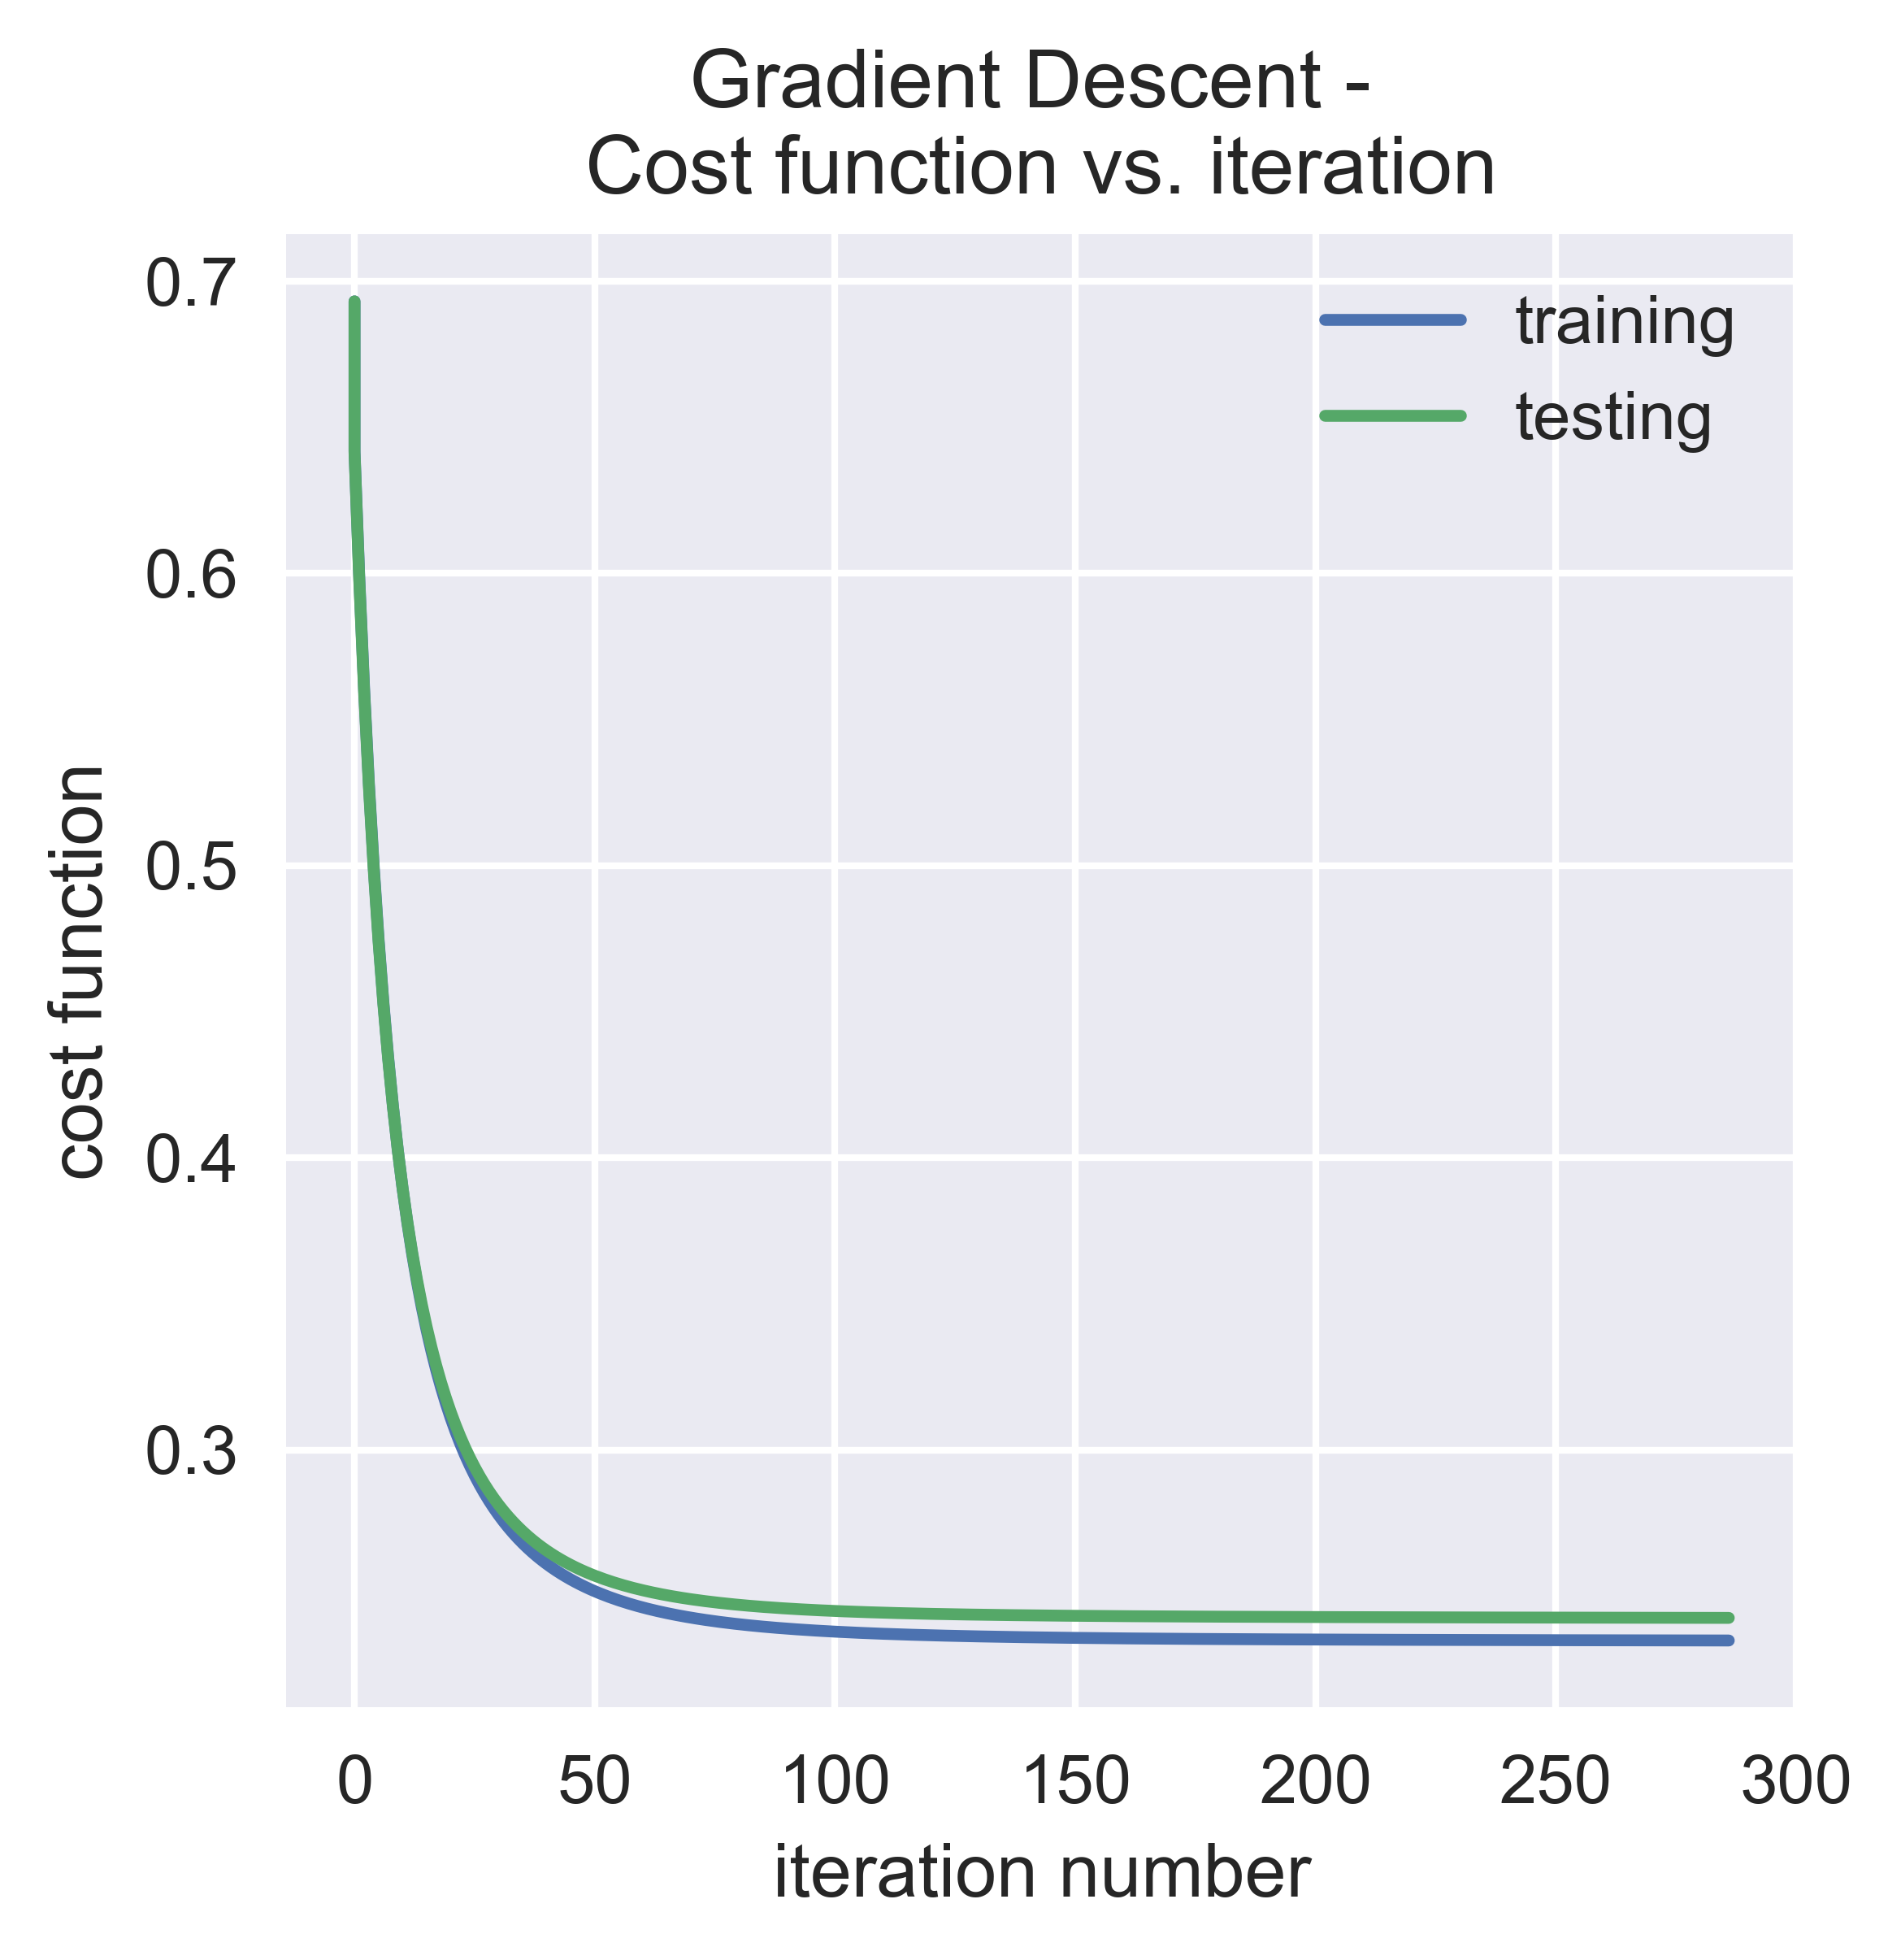

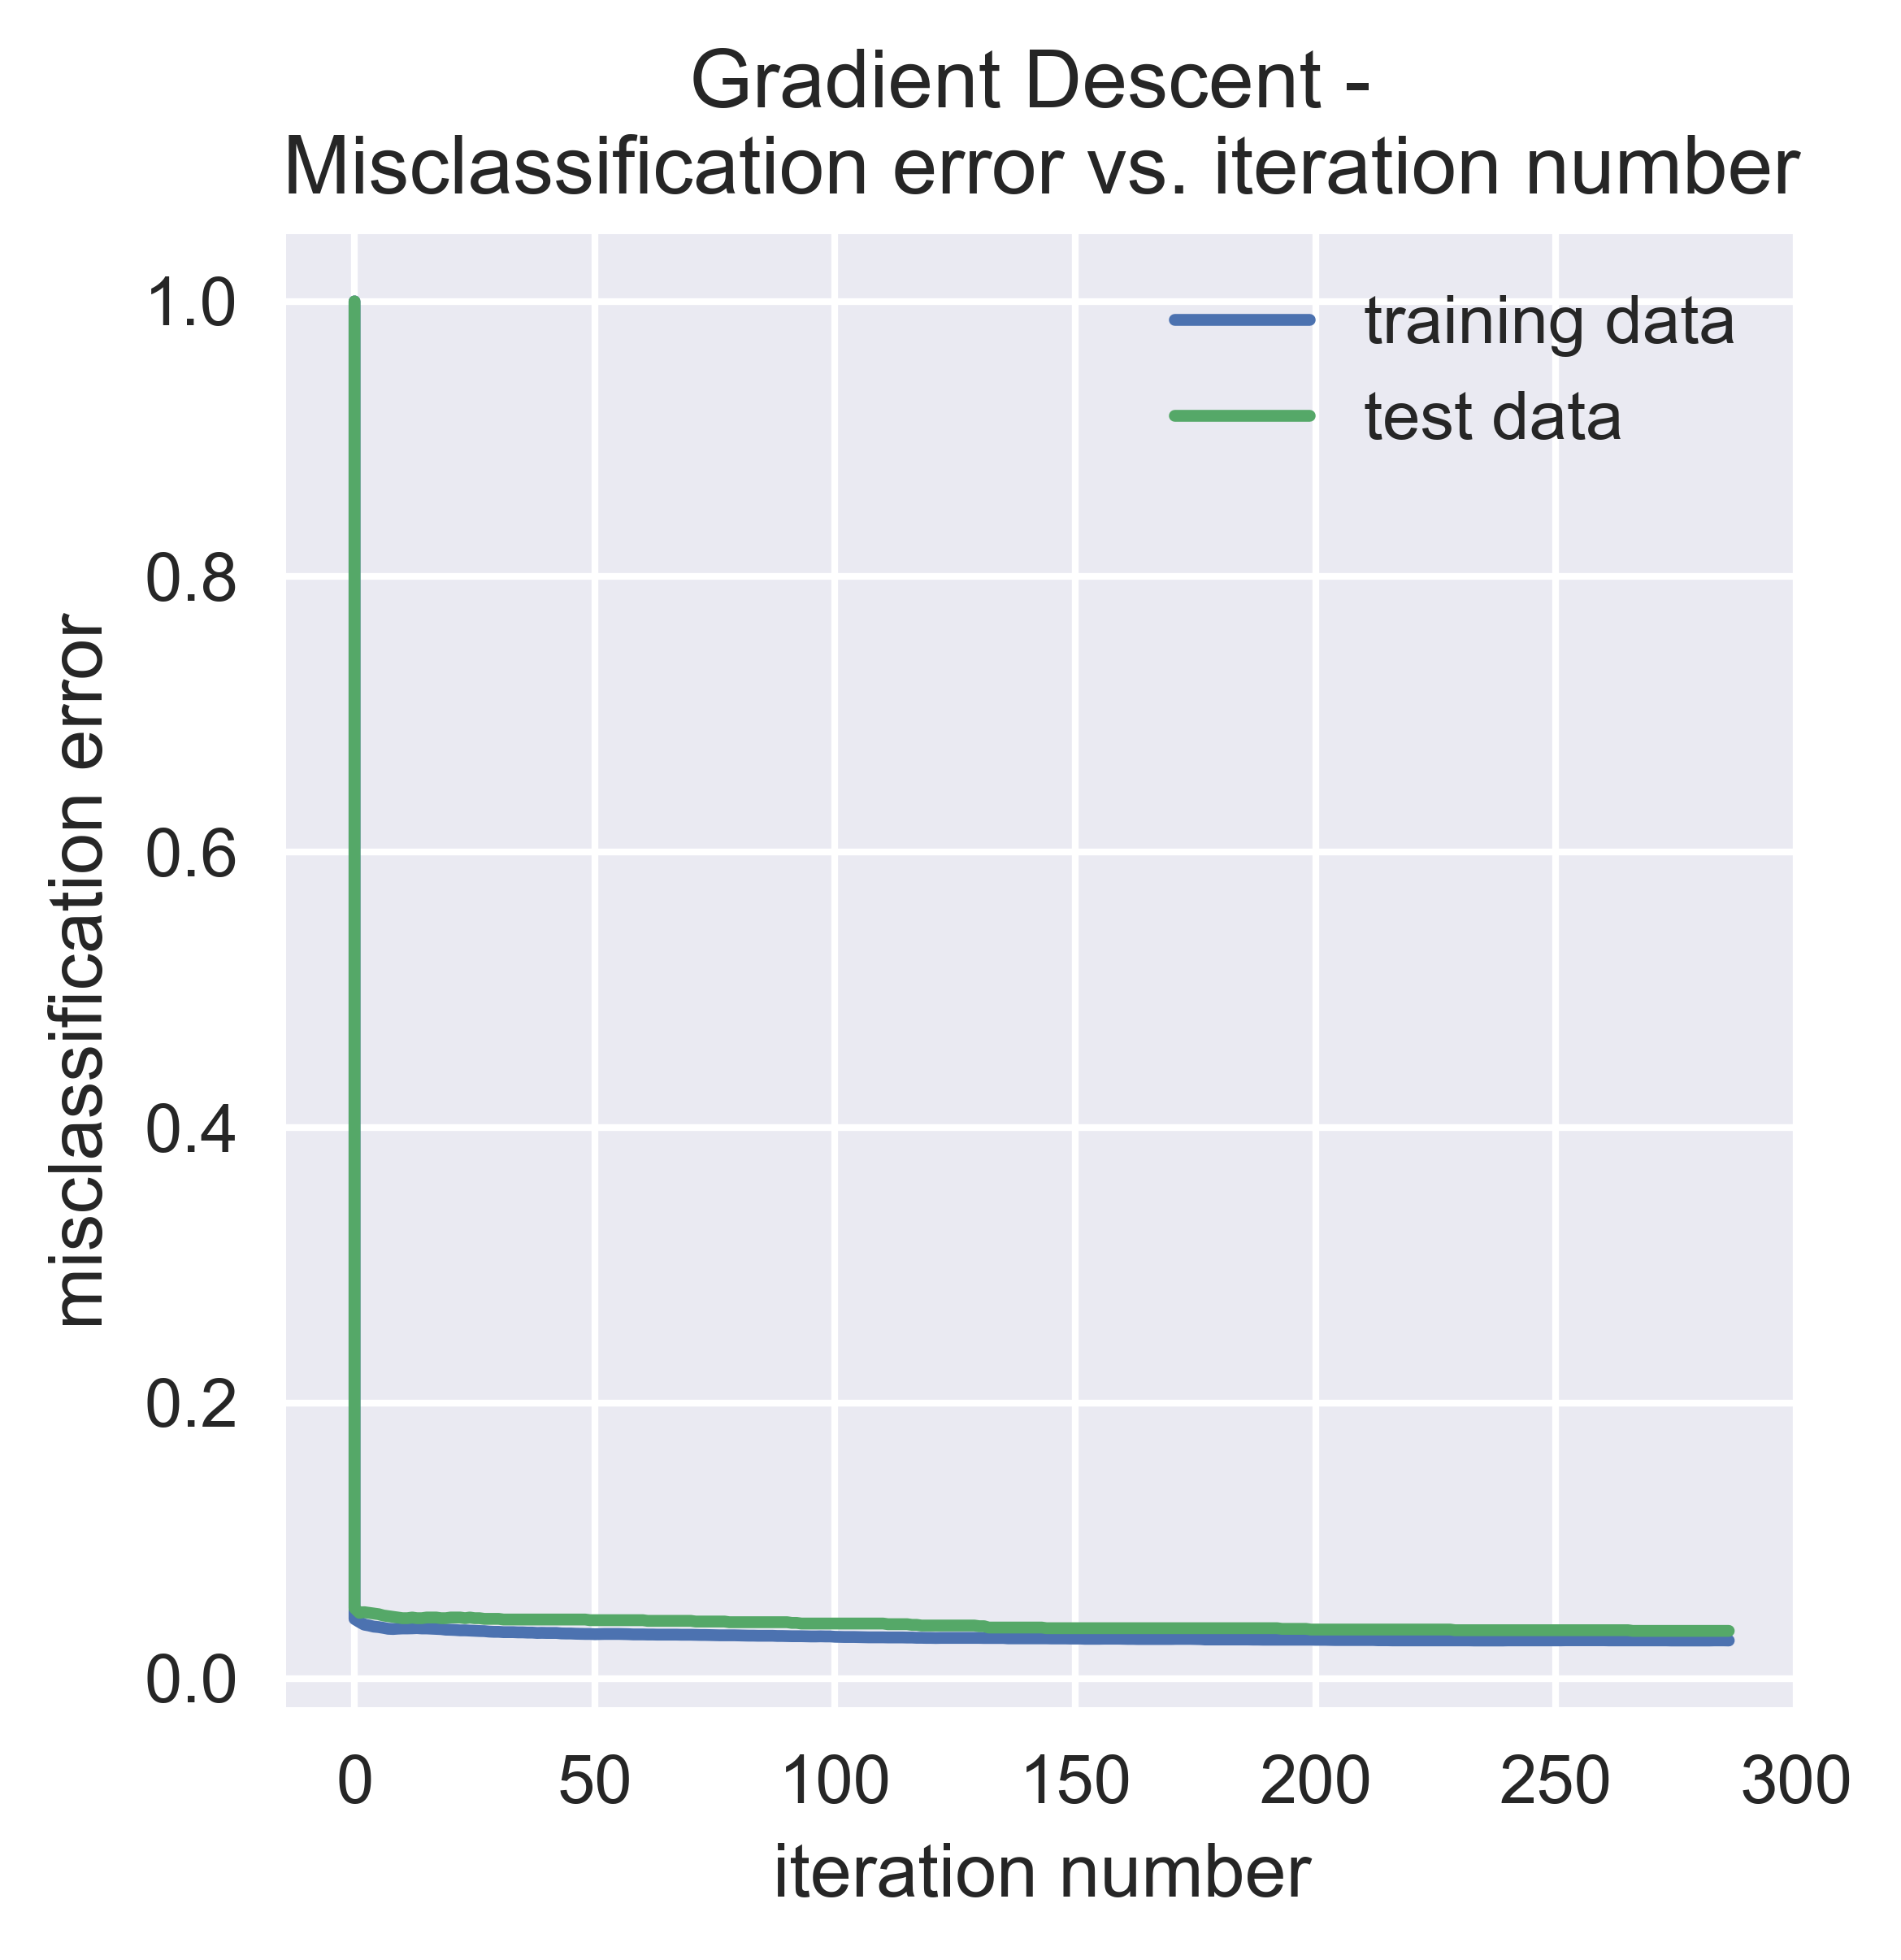

In [58]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Gradient Descent - \n')

### stochastic gradient descent - 1 example

In [41]:
batch_size = 1
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = SGD(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val,batch_size)

the value of j train is 0.6931471805599452
the value of j train is 0.7022670202220552
the value of j train is 0.8663727326330192
the value of j train is 0.9704654721815088
the value of j train is 0.6205748952122988
the value of j train is 0.5061947822440422
the value of j train is 0.540752195674124
the value of j train is 0.6000818977932347
the value of j train is 0.6446435747822091
the value of j train is 0.7416975064805743
the value of j train is 0.48049027731846233
the value of j train is 0.4946088709296761
the value of j train is 0.517465860881372
the value of j train is 0.4105824754389989
the value of j train is 0.31726303970441827
the value of j train is 0.31914316561725764
the value of j train is 0.30072787153147096
the value of j train is 0.3977322010429574
the value of j train is 0.40603382829662177
the value of j train is 0.30282474018778643
the value of j train is 0.30579863815737424
the value of j train is 0.31837706602662685
the value of j train is 0.31158327500174354
the 

the value of j train is 0.2529860660764661
the value of j train is 0.24931324570861355
the value of j train is 0.2505024492567649
the value of j train is 0.25306285791923594
the value of j train is 0.259506623410037
the value of j train is 0.2575998151030629
the value of j train is 0.3046886167541694
the value of j train is 0.30396339146452944
the value of j train is 0.2871202878169241
the value of j train is 0.288839684767489
the value of j train is 0.2994545438172191
the value of j train is 0.3023246352284503
the value of j train is 0.31873012713192994
the value of j train is 0.3363844890276133
the value of j train is 0.26366794619298417
the value of j train is 0.2768545250353748
the value of j train is 0.2624150619116811
the value of j train is 0.2601607320456623
the value of j train is 0.2563854920418821
the value of j train is 0.27144526829211524
the value of j train is 0.26399073652223337
the value of j train is 0.2665367346062079
the value of j train is 0.2763940055182588
the va

the value of j train is 0.28233403220899844
the value of j train is 0.2745085205888559
the value of j train is 0.27393863697257625
the value of j train is 0.2669033922801053
the value of j train is 0.2828773784055556
the value of j train is 0.275240502663321
the value of j train is 0.2712081121077142
the value of j train is 0.26415446970851136
the value of j train is 0.25936032042947194
the value of j train is 0.26207703104948626
the value of j train is 0.25744736755804765
the value of j train is 0.2709647216413148
the value of j train is 0.2754534523459211
the value of j train is 0.2630003322784807
the value of j train is 0.2567275769308061
the value of j train is 0.25489370725725274
the value of j train is 0.2548570011297887
the value of j train is 0.25867244097968256
the value of j train is 0.2573290584365777
the value of j train is 0.2591645523807977
the value of j train is 0.2541323356570666
the value of j train is 0.2678009803441298
the value of j train is 0.27219685209563005
the

the value of j train is 0.2601641815459781
the value of j train is 0.26075795304781046
the value of j train is 0.2732965849345824
the value of j train is 0.27350587390989345
the value of j train is 0.26646337665927117
the value of j train is 0.2597270388371108
the value of j train is 0.27962062250723024
the value of j train is 0.27254917366653647
the value of j train is 0.2655617806822469
the value of j train is 0.29845768463051214
the value of j train is 0.2989644936004318
the value of j train is 0.2981391808950445
the value of j train is 0.2636298328519341
the value of j train is 0.2604978470085112
the value of j train is 0.26004882264805707
the value of j train is 0.2594973487527641
the value of j train is 0.25848685547811845
the value of j train is 0.2580831126516431
the value of j train is 0.2572579841708272
the value of j train is 0.258024620600092
the value of j train is 0.25803269980086957
the value of j train is 0.2707776071888658
the value of j train is 0.3042164932949418
the

the value of j train is 0.25817738235952925
the value of j train is 0.2575258213781364
the value of j train is 0.2569471304031379
the value of j train is 0.2567114835151061
the value of j train is 0.2744957248810399
the value of j train is 0.2629993761144969
the value of j train is 0.257746658011065
the value of j train is 0.2564026624662996
the value of j train is 0.25529418820290545
the value of j train is 0.2544910483724927
the value of j train is 0.25435880045057085
the value of j train is 0.2536928659729618
the value of j train is 0.2533961213909515
the value of j train is 0.25275558279335425
the value of j train is 0.2974065029326042
the value of j train is 0.2979344780997259
the value of j train is 0.2843599550430258
the value of j train is 0.2843503593568747
the value of j train is 0.4311175565709873
the value of j train is 0.44706322384296127
the value of j train is 0.34966595895992064
the value of j train is 0.35678793613355597
the value of j train is 0.3579394743645003
the v

the value of j train is 0.2526059366420119
the value of j train is 0.2520592132511747
the value of j train is 0.25455173460176805
the value of j train is 0.2528291297741827
the value of j train is 0.2532035909444654
the value of j train is 0.46171086229864067
the value of j train is 0.46165552405700616
the value of j train is 0.480454945025826
the value of j train is 0.32470652817081636
the value of j train is 0.30030808919495156
the value of j train is 0.30267586917072475
the value of j train is 0.2837945079142906
the value of j train is 0.28954707812246994
the value of j train is 0.2709453361562707
the value of j train is 0.2664572394493563
the value of j train is 0.2660008605232267
the value of j train is 0.27182564052589664
the value of j train is 0.27789174613914336
the value of j train is 0.28098579046028216
the value of j train is 0.29483351834677796
the value of j train is 0.307466704768041
the value of j train is 0.3047975190546188
the value of j train is 0.3068153422674685
th

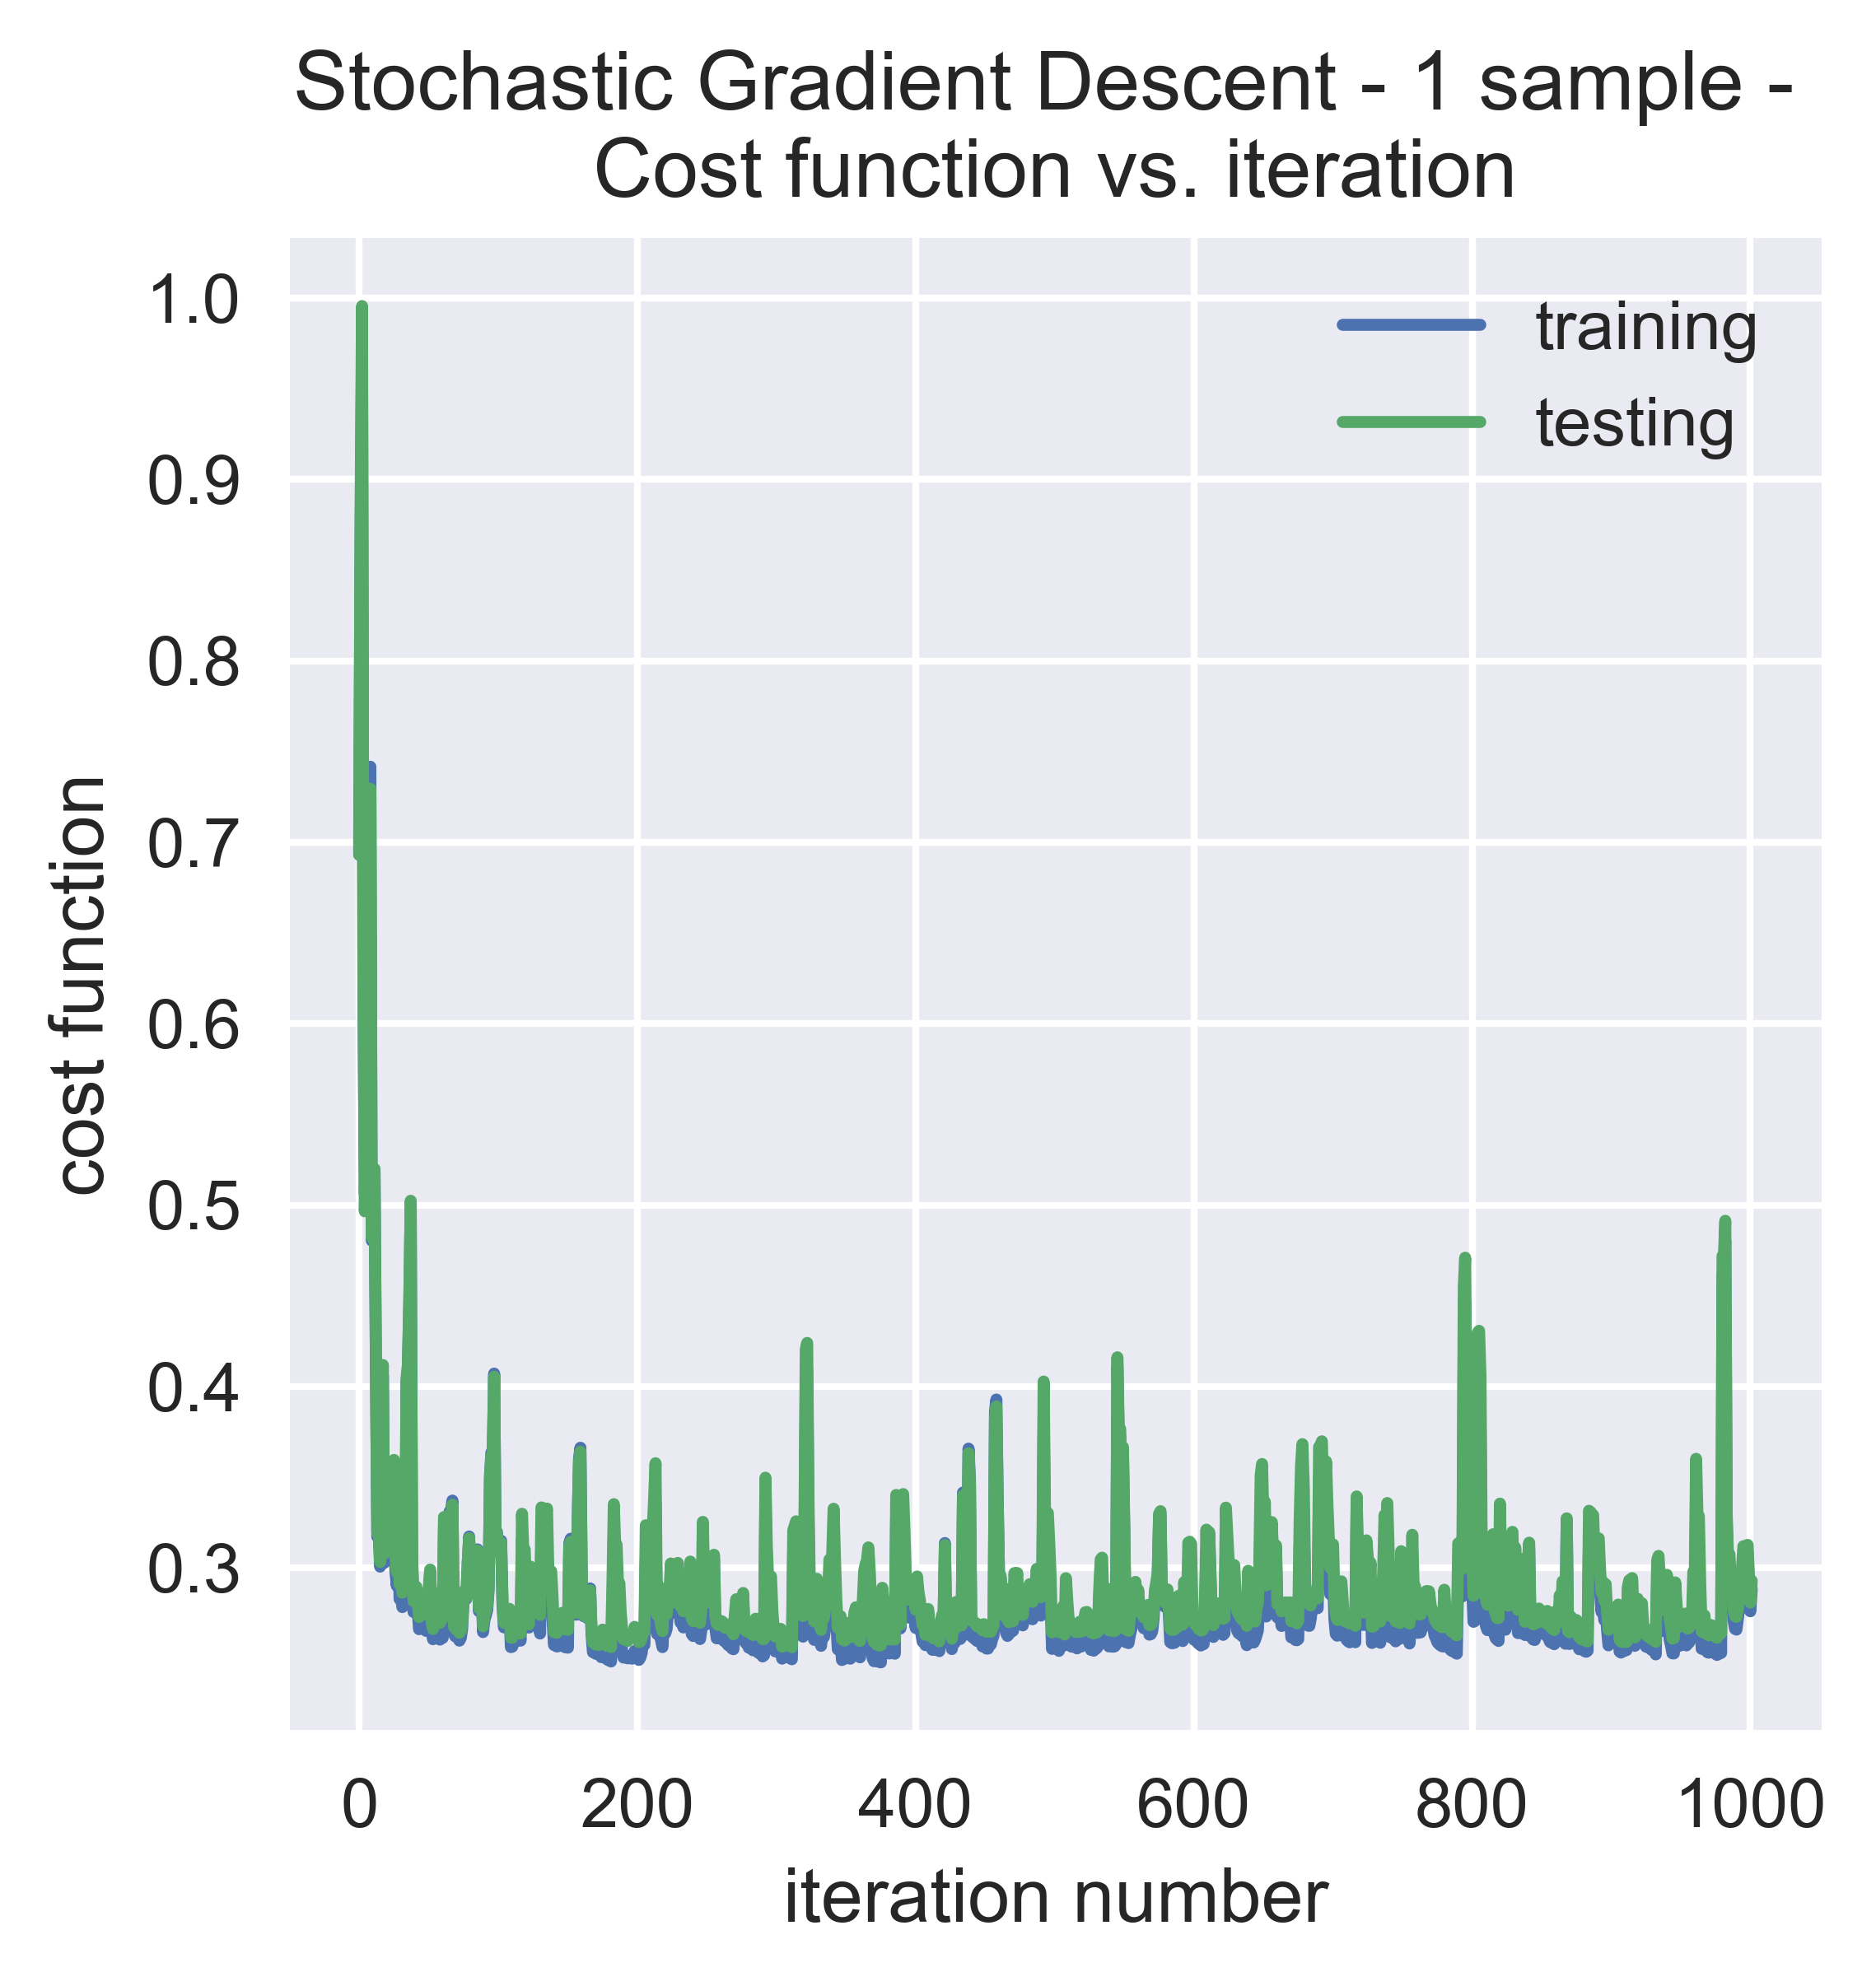

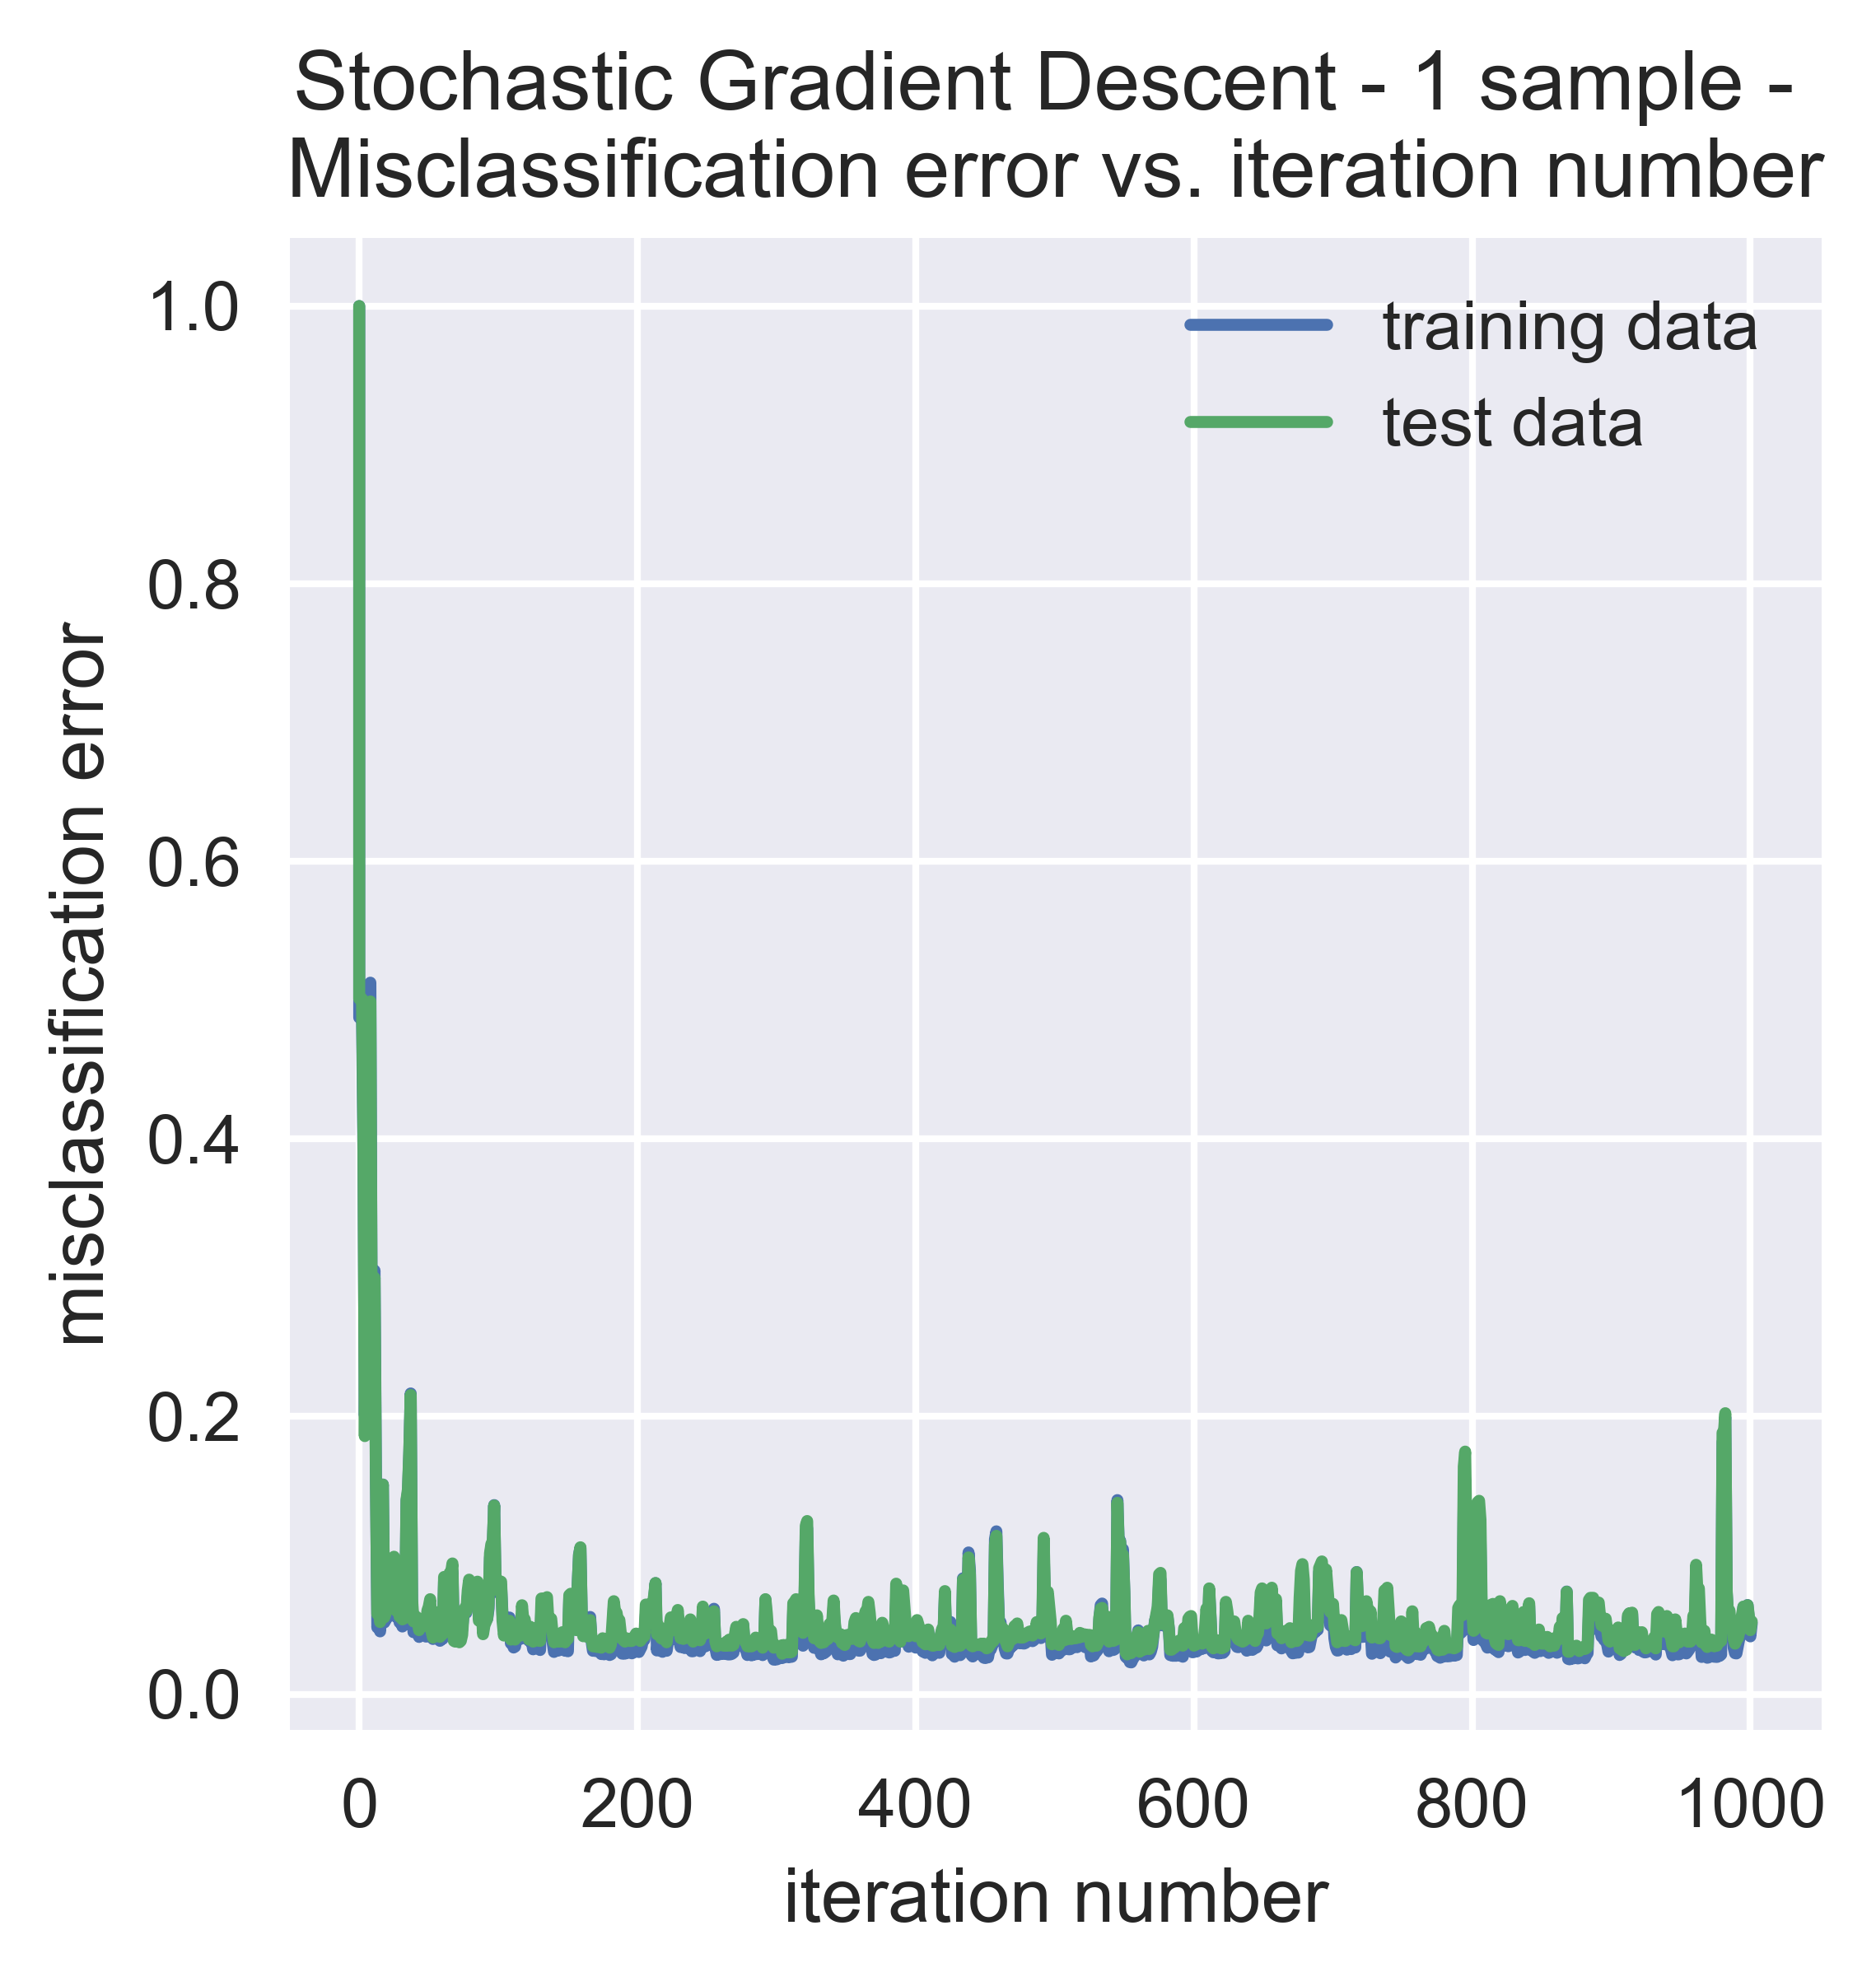

In [42]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Stochastic Gradient Descent - 1 sample - \n')

### stochastic gradient descent - batch size 100

In [43]:
batch_size = 100 
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = SGD(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val,batch_size)

the value of j train is 0.6931471805599452
the value of j train is 0.6064629021437161
the value of j train is 0.5422399298999553
the value of j train is 0.4910290917868024
the value of j train is 0.45154116541656814
the value of j train is 0.41956021232814195
the value of j train is 0.39613526657272313
the value of j train is 0.3755113808810514
the value of j train is 0.36198806830758046
the value of j train is 0.34536759692688757
the value of j train is 0.3332483884644973
the value of j train is 0.323101224724285
the value of j train is 0.31448133357155383
the value of j train is 0.3056226972400517
the value of j train is 0.29892430724901736
the value of j train is 0.2936489437444679
the value of j train is 0.2883720331259668
the value of j train is 0.2832261367877534
the value of j train is 0.27956565573944575
the value of j train is 0.2787796551661657
the value of j train is 0.2732502586695891
the value of j train is 0.269742544114897
the value of j train is 0.2666207476688185
the v

the value of j train is 0.23493865360691432
the value of j train is 0.23493950270377423
the value of j train is 0.23501992510105246
the value of j train is 0.2352156091748639
the value of j train is 0.23504788568753202
the value of j train is 0.23499081441382697
the value of j train is 0.2349589396130643
the value of j train is 0.23489206350446992
the value of j train is 0.23492941561110692
the value of j train is 0.23484603986832905
the value of j train is 0.23494117397026634
the value of j train is 0.23511102624982538
the value of j train is 0.23500367061842875
the value of j train is 0.23487175218996922
the value of j train is 0.234847350917919
the value of j train is 0.23495838838217764
the value of j train is 0.2348828598379631
the value of j train is 0.23484190872148056
the value of j train is 0.23490248890551102
the value of j train is 0.23492481369089313
the value of j train is 0.23504100133901312
the value of j train is 0.2348943011787782
the value of j train is 0.234860909273

the value of j train is 0.23459035833503677
the value of j train is 0.23458764749508873
the value of j train is 0.2345414894195927
the value of j train is 0.23454262336147386
the value of j train is 0.23455726130941248
the value of j train is 0.23456054932228249
the value of j train is 0.2347478668181588
the value of j train is 0.23477963015388376
the value of j train is 0.23471356230579898
the value of j train is 0.23457754029706845
the value of j train is 0.23457561812187222
the value of j train is 0.23481111501817137
the value of j train is 0.2350010437254893
the value of j train is 0.23506236187685609
the value of j train is 0.23458092042377446
the value of j train is 0.23453493085033839
the value of j train is 0.23453881853170955
the value of j train is 0.23462612711968647
the value of j train is 0.23465166003509536
the value of j train is 0.23466755294881864
the value of j train is 0.234654121887251
the value of j train is 0.23456206338478686
the value of j train is 0.23465756639

the value of j train is 0.2342740516801
the value of j train is 0.23420150917927365
the value of j train is 0.2342360000589827
the value of j train is 0.2344783556265454
the value of j train is 0.23498710640039208
the value of j train is 0.2348311637893396
the value of j train is 0.2344389823805308
the value of j train is 0.23444901483501096
the value of j train is 0.23468423271192188
the value of j train is 0.23489908620521793
the value of j train is 0.2350539189212942
the value of j train is 0.23472738369868687
the value of j train is 0.2351410023970409
the value of j train is 0.23460260286394097
the value of j train is 0.2343644733813716
the value of j train is 0.23445929661139694
the value of j train is 0.23433000899770826
the value of j train is 0.23484809818646663
the value of j train is 0.23421554641266934
the value of j train is 0.23418945907253824
the value of j train is 0.23423650413904606
the value of j train is 0.23420788700884418
the value of j train is 0.23420441696430133

the value of j train is 0.23446347246113708
the value of j train is 0.23428376552300437
the value of j train is 0.23429867572856838
the value of j train is 0.23458934996736674
the value of j train is 0.2342669608590807
the value of j train is 0.2341402116291755
the value of j train is 0.23405211375655885
the value of j train is 0.23405906607732513
the value of j train is 0.23406346579230225
the value of j train is 0.23410889763194487
the value of j train is 0.23407530198841808
the value of j train is 0.23404771625974702
the value of j train is 0.234161136924571
the value of j train is 0.23403086749724264
the value of j train is 0.23403339763303
the value of j train is 0.23407726040390148
the value of j train is 0.23406055468061454
the value of j train is 0.23414427399909593
the value of j train is 0.2342697085923457
the value of j train is 0.23425045903580421
the value of j train is 0.23458364716585772
the value of j train is 0.23568955217365128
the value of j train is 0.23523960115218

the value of j train is 0.2338640027356636
the value of j train is 0.23396553959992694
the value of j train is 0.23396603575766128
the value of j train is 0.2339236063159034
the value of j train is 0.23386232810241395
the value of j train is 0.23390580758554064
the value of j train is 0.23386869659153003
the value of j train is 0.23398150901284187
the value of j train is 0.2340168849397436
the value of j train is 0.23411900869605018
the value of j train is 0.2340467939758002
the value of j train is 0.2341601401538203
the value of j train is 0.23433231381950004
the value of j train is 0.2338856196331801
the value of j train is 0.23400977926027772
the value of j train is 0.23384777058509826


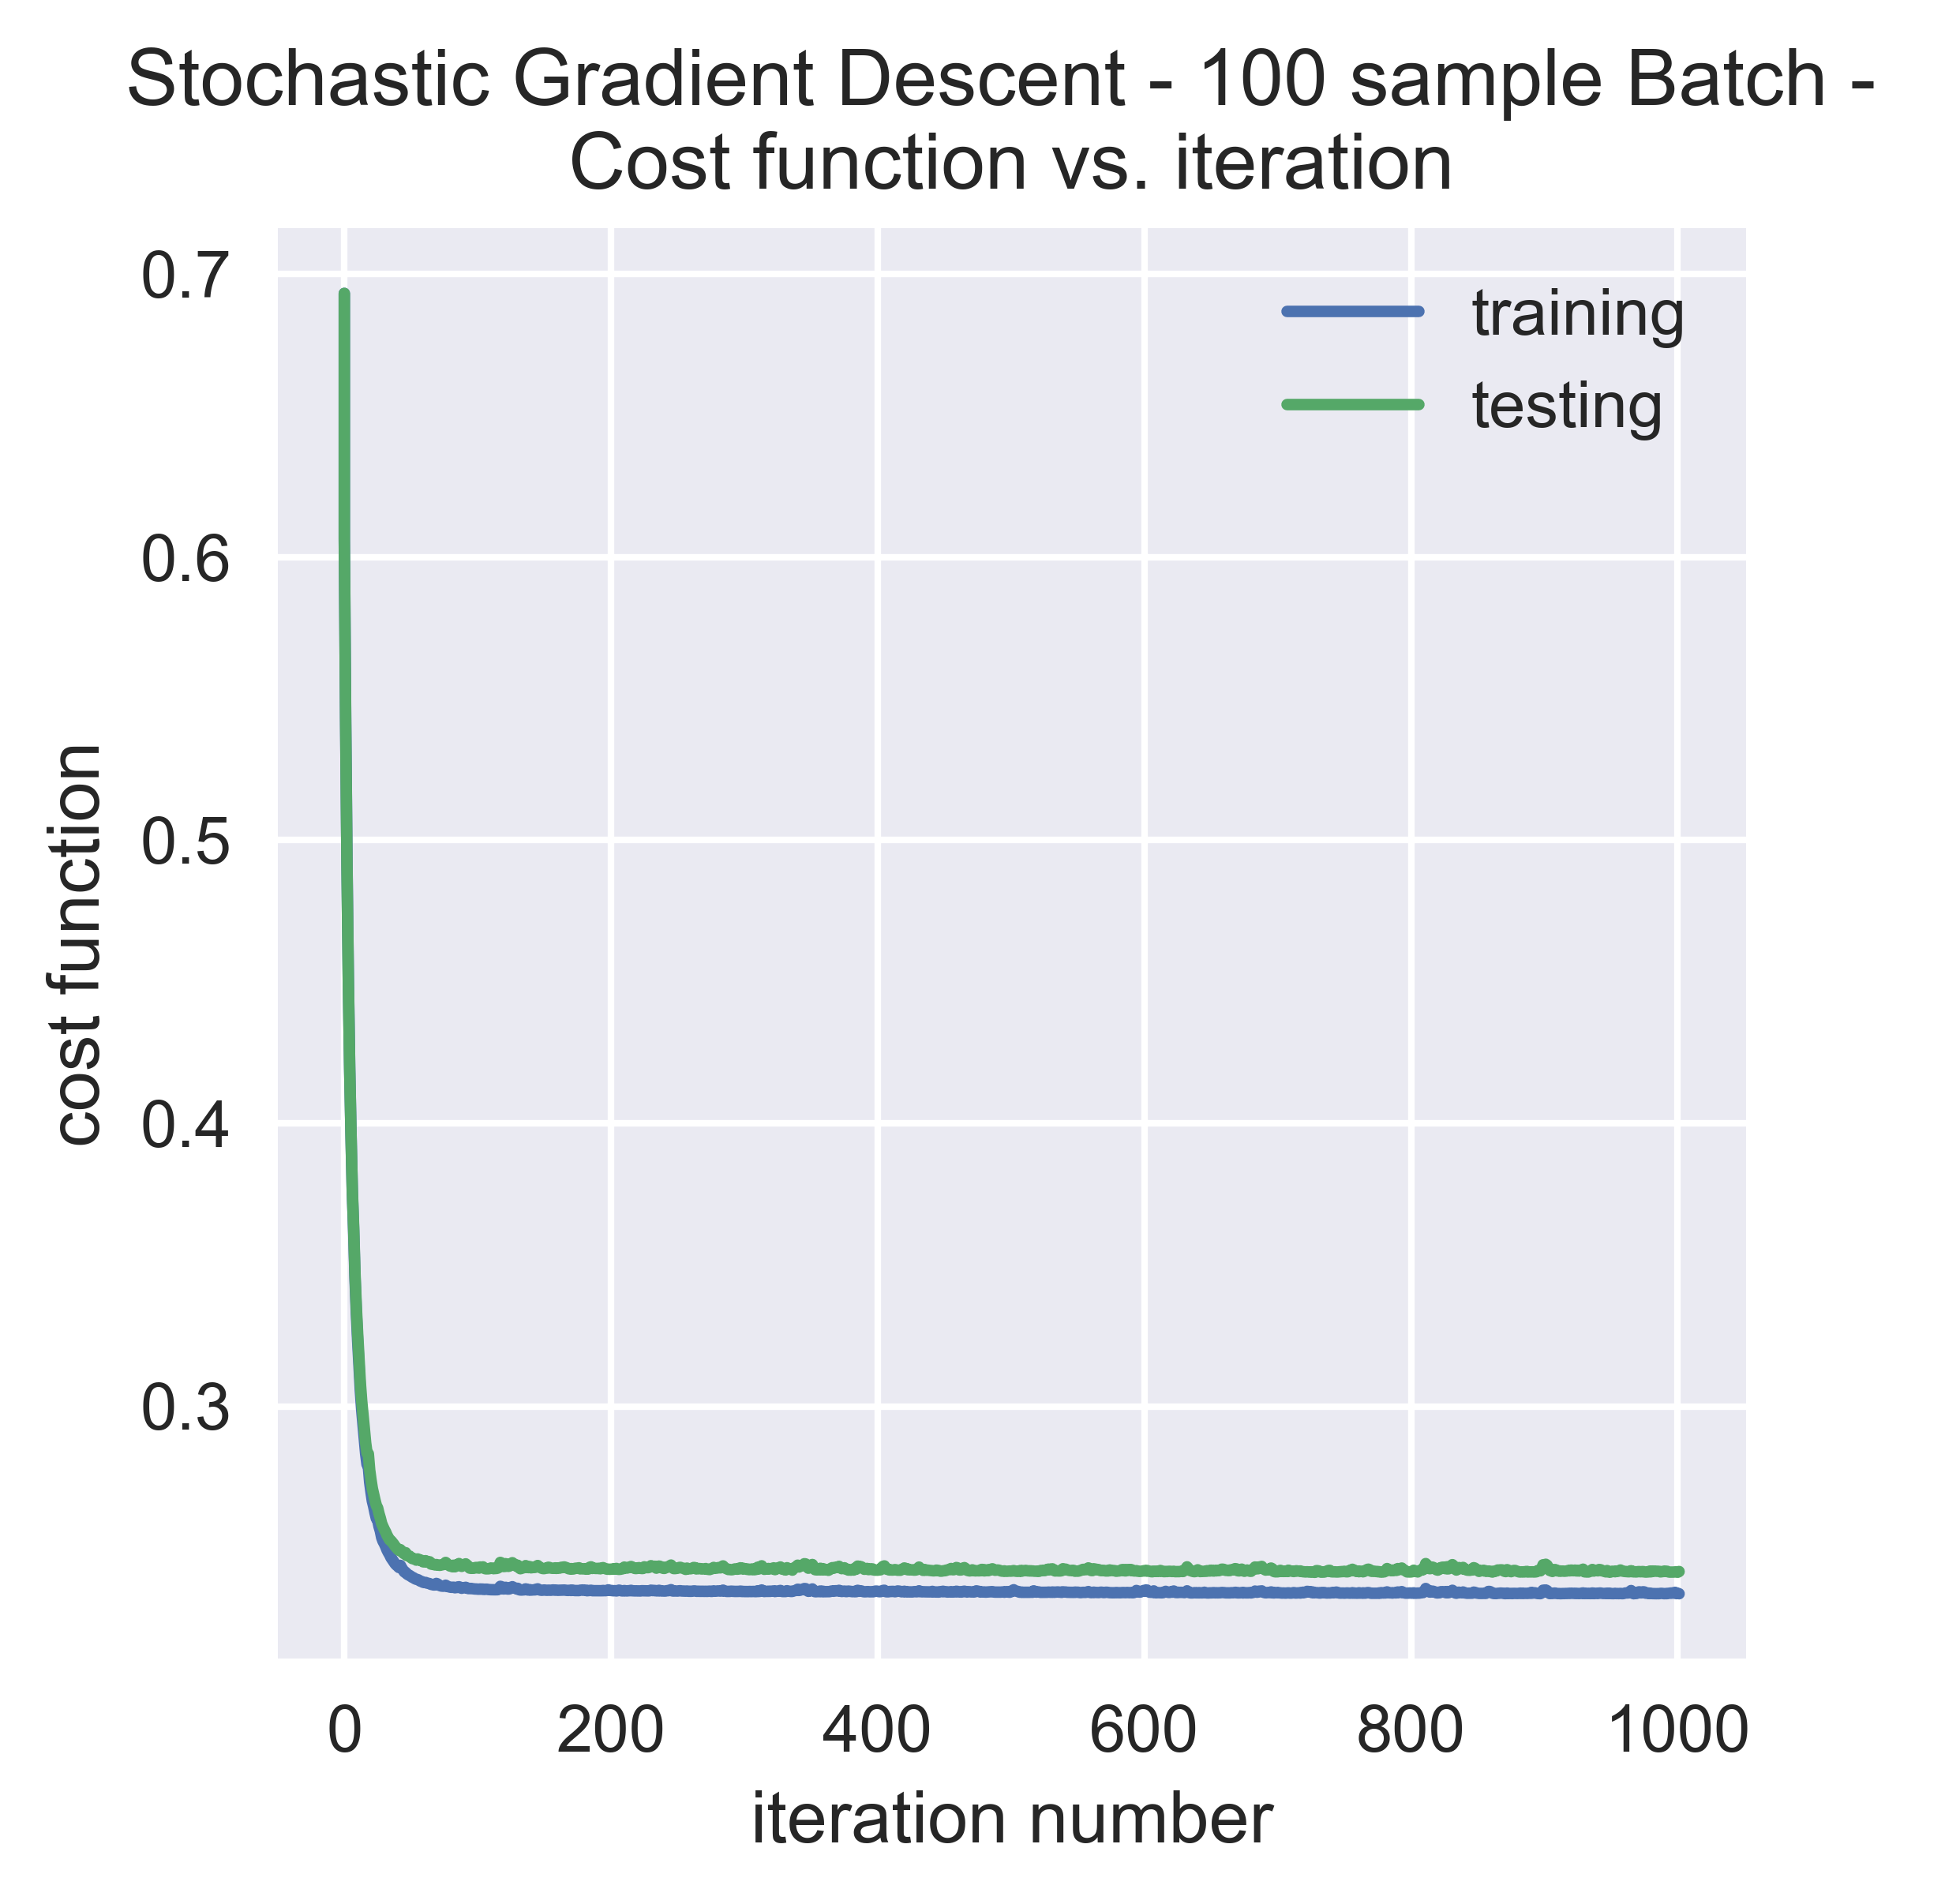

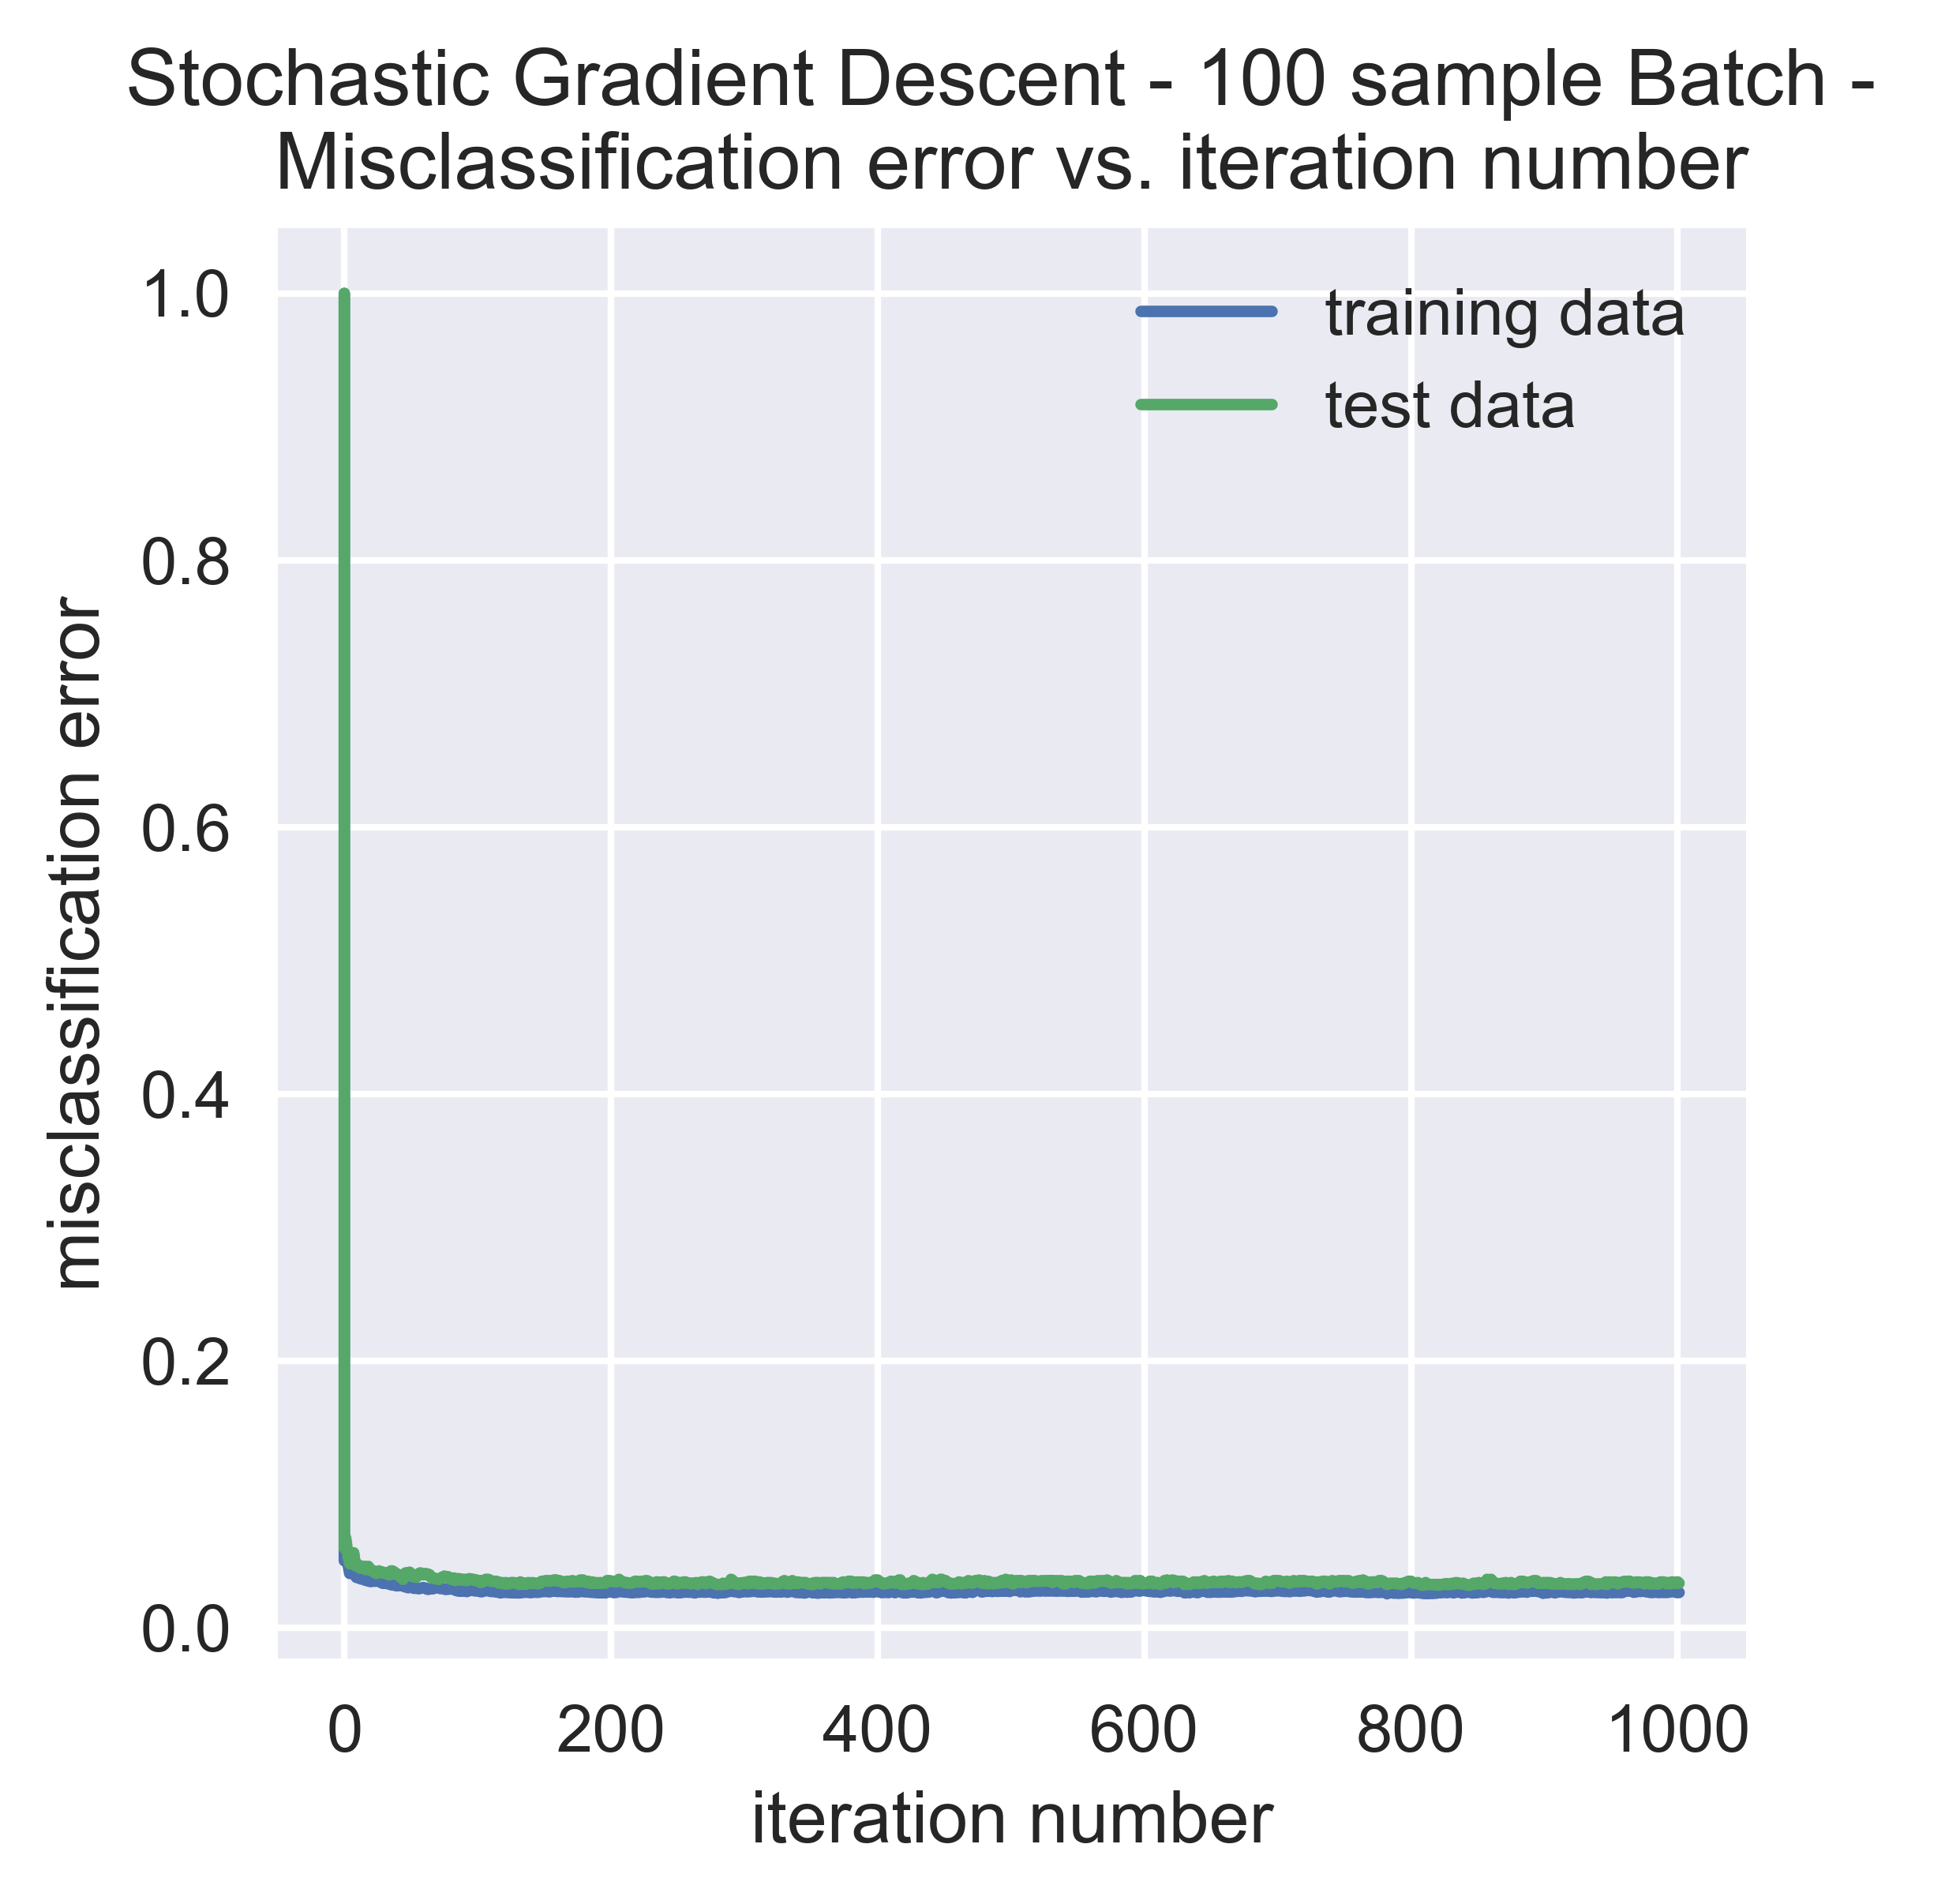

In [44]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Stochastic Gradient Descent - 100 sample Batch - \n')

### newton's method 

In [38]:
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = newton_method(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val)

the value of j train is 0.6931471805599452
the value of j train is 0.2735230172832013
0.0154463851117
the value of j train is 0.23791090757852226
0.00880467982396
the value of j train is 0.2360846695949867
0.00508768727408
the value of j train is 0.23559638039319708
0.00432852530296
the value of j train is 0.23521462372384072
0.00389574853352


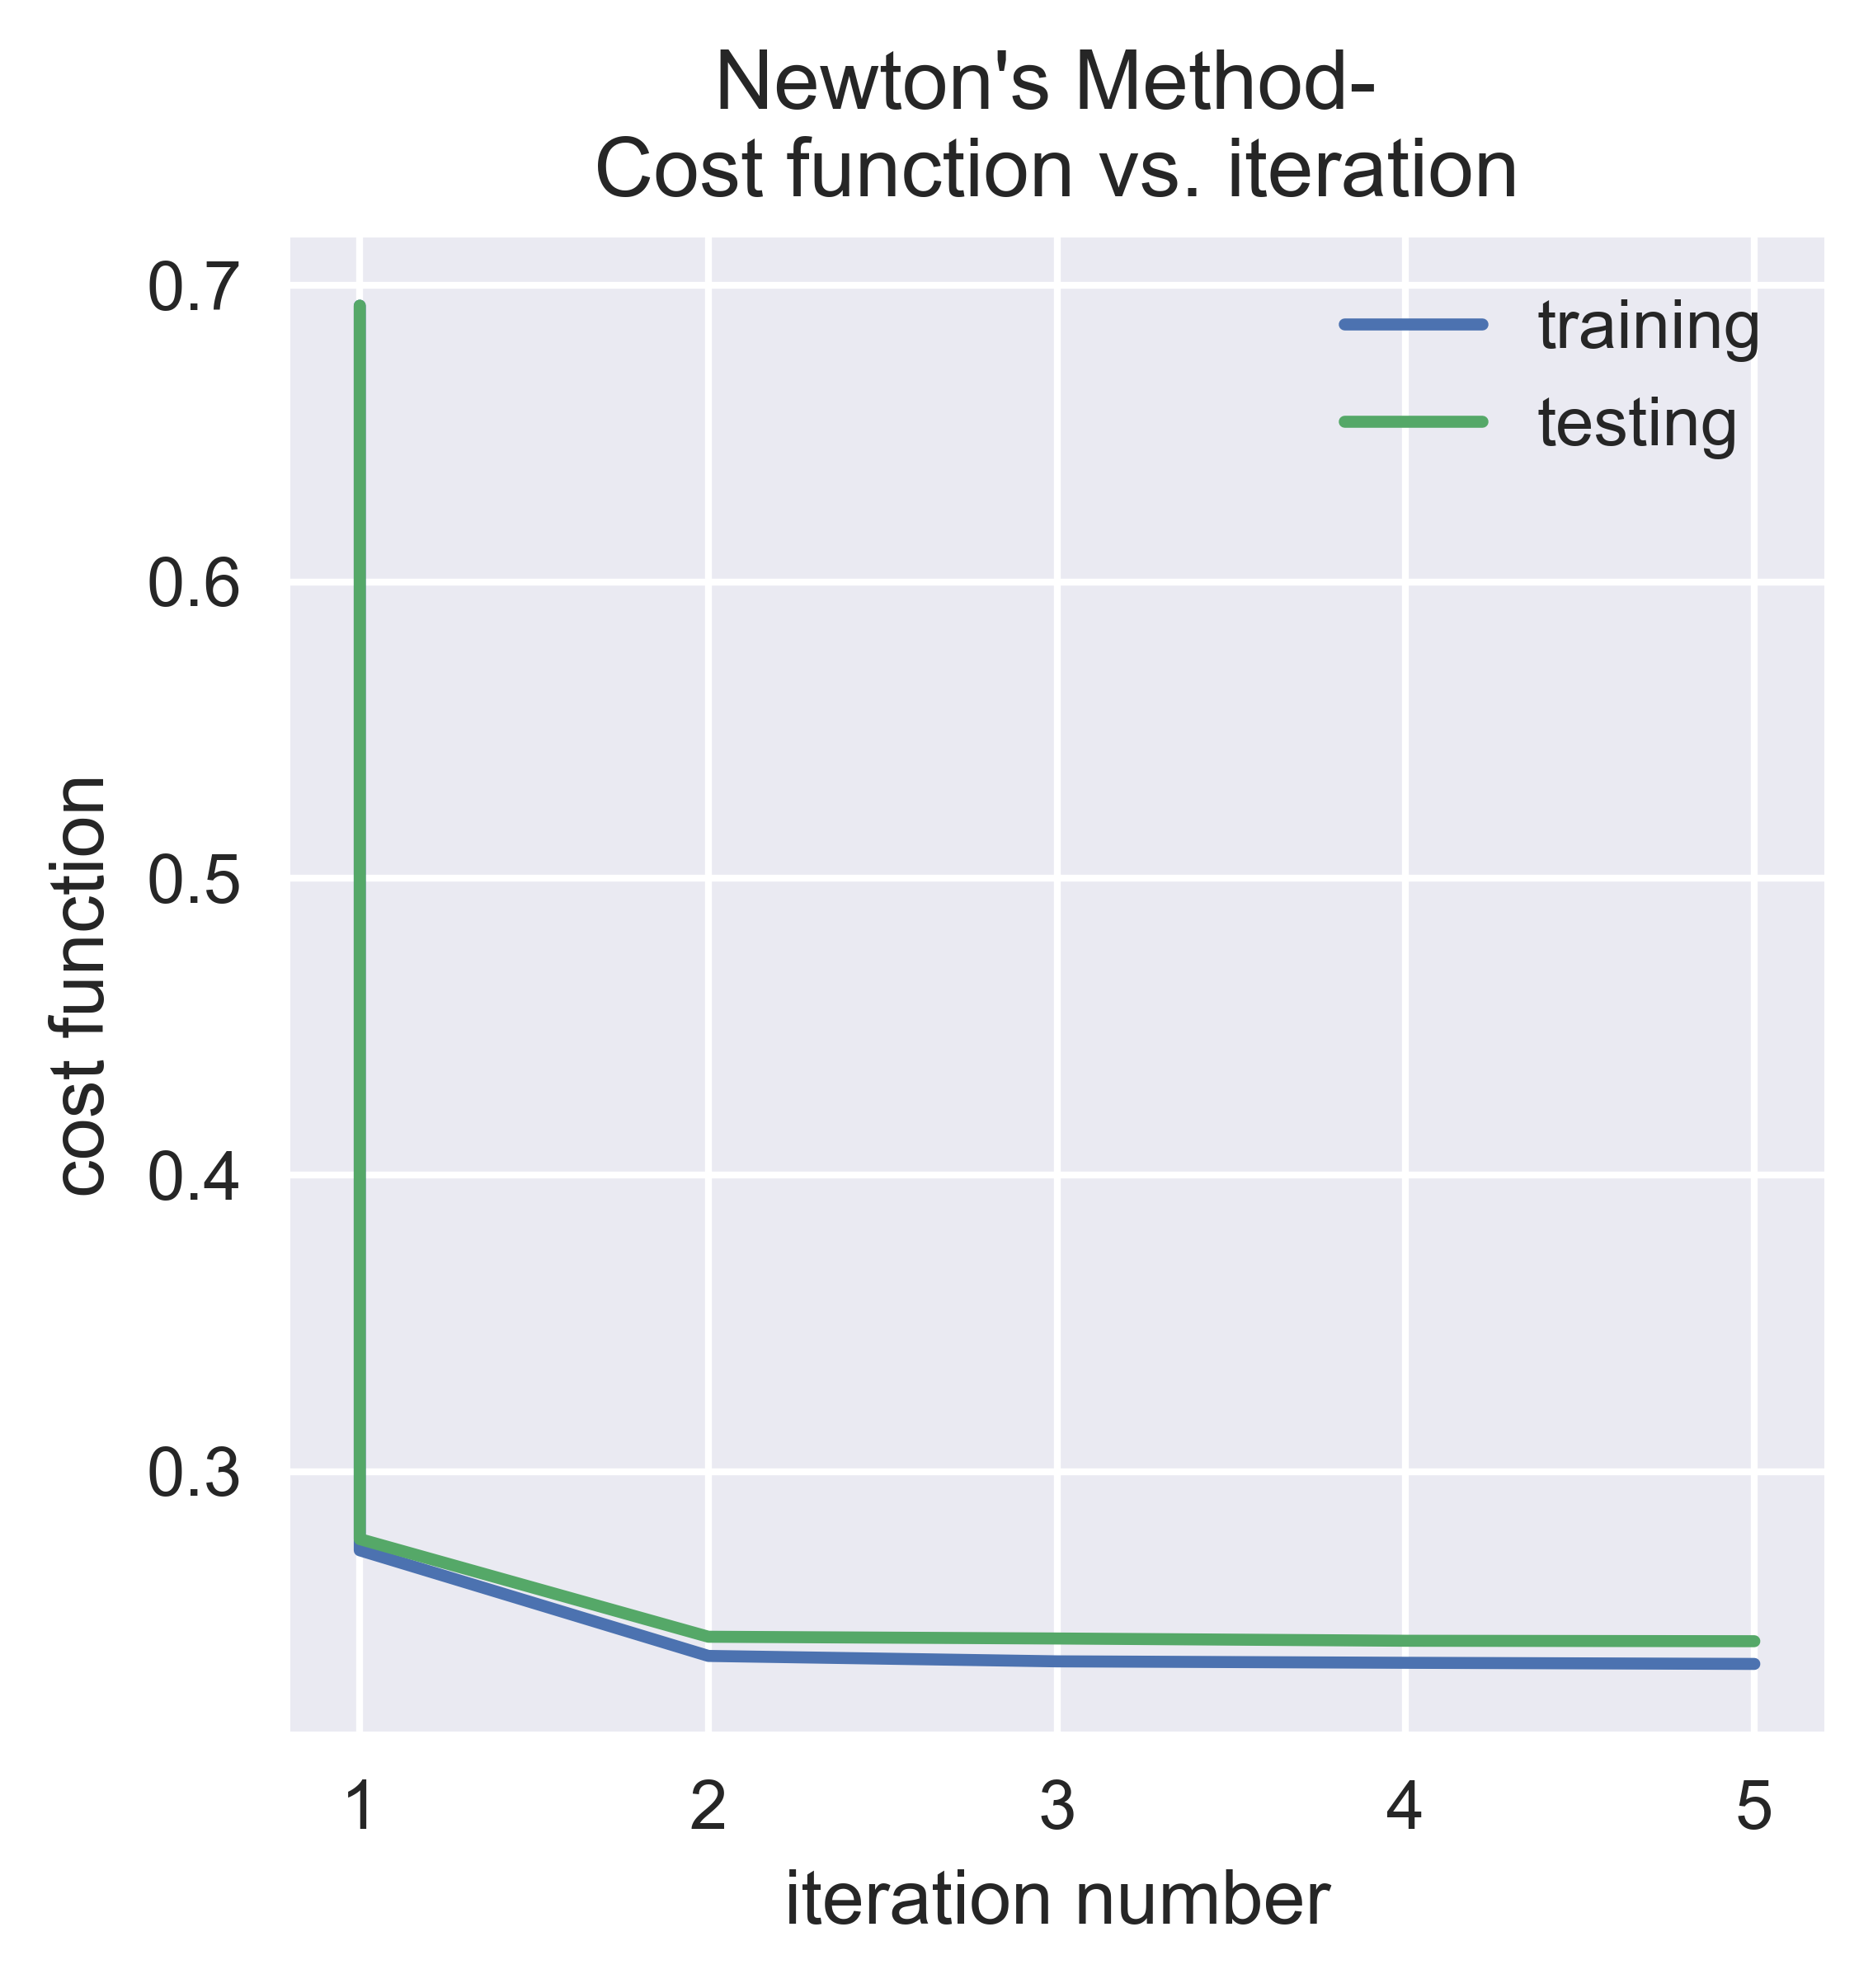

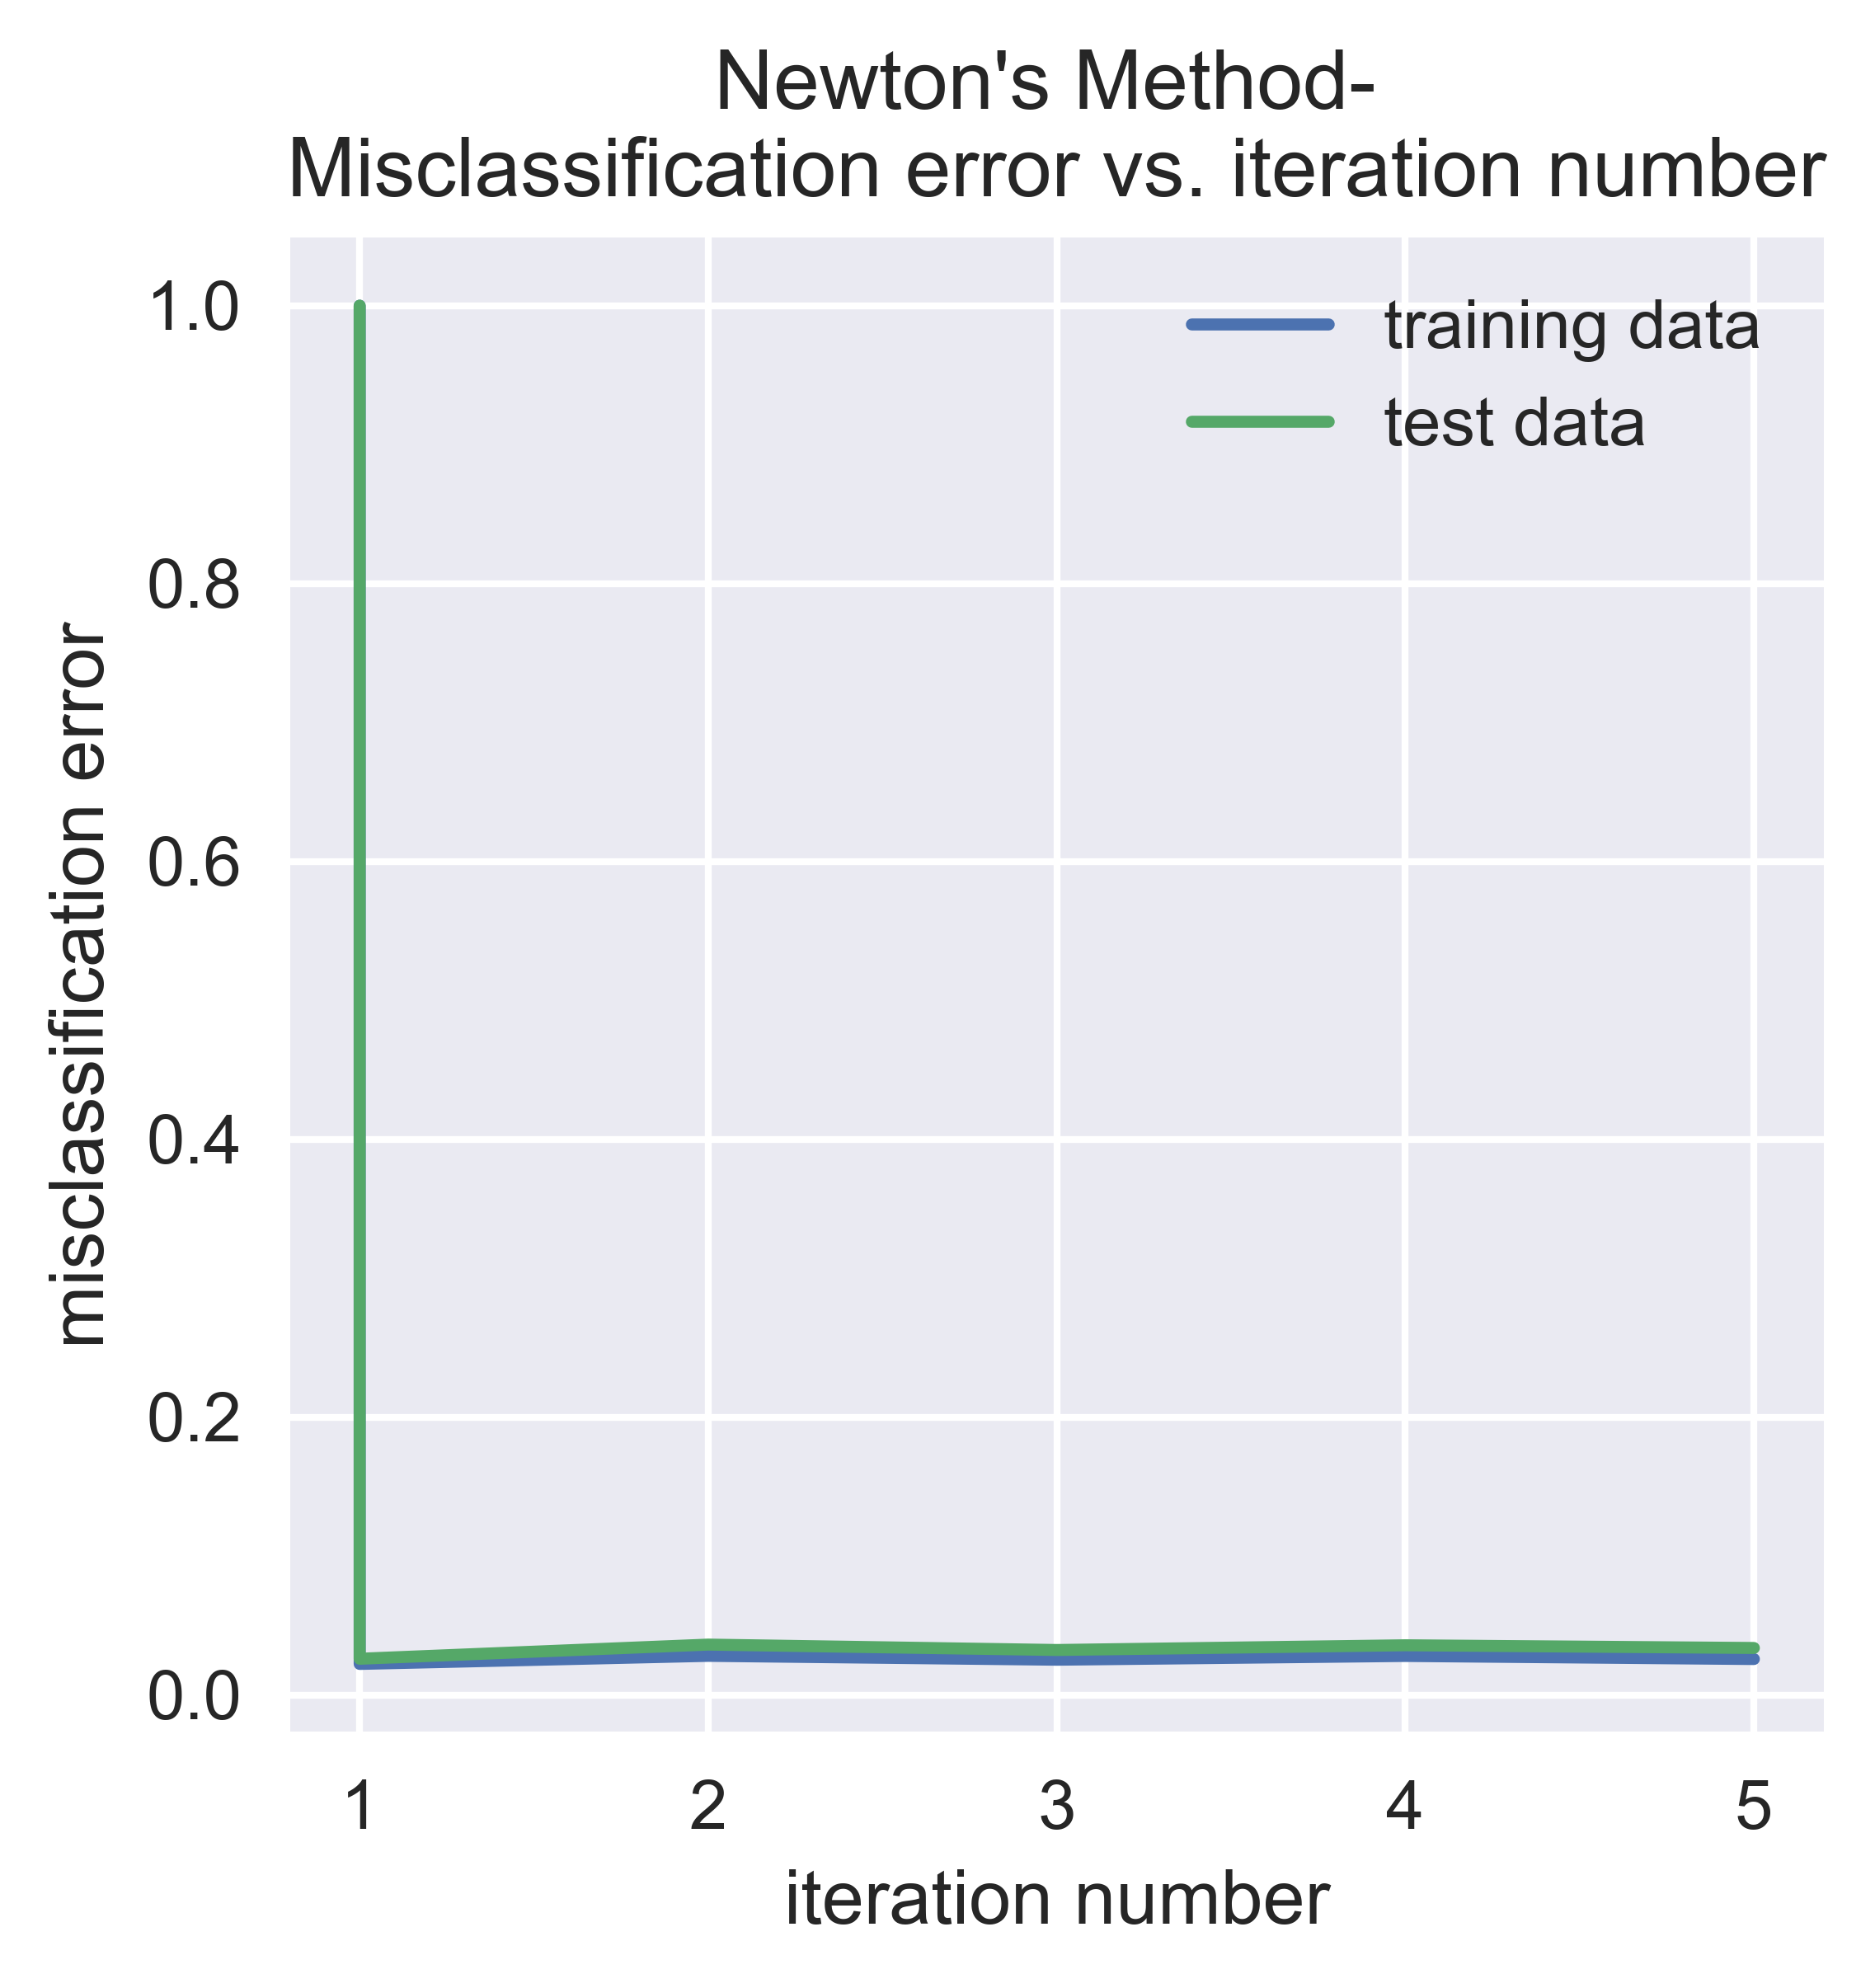

In [39]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Newton\'s Method- \n')

### batch

### this is scratch below here

In [ ]:
X = x_train_c
y = labels_train_c
X_test = x_test_c
y_test = labels_test_c

not_conv = True
j_train_vec = []
j_test_vec = []
w_vec = []
b_vec = []
k_vec = []
train_classify_vec = []
test_classify_vec = []

k = 0
#step_size = 1e-3
step_size = 5e-2
criteria_conv = 2e-4

w = np.zeros((np.shape(X)[1],))
b = 0
n = np.shape(X)[0]
#mu_vec = np.zeros((np.shape(X)[0],))
#cost_mu = np.zeros((np.shape(X)[0],))
#range_vec = np.arange(len(mu_vec))
j_prev = 0

while not_conv:
    ##### training part 
    #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
    #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
    mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 
    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))
     
    #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
    #g_b = (1/n)*np.sum(mu_vec-y)
    
    g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
    g_b = (1/n)*np.sum(-y*(1-mu_vec))
    
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    ####### testing part
    
    mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
    cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))
    
    j_test = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

    # 
    w_new = w - step_size*g_w
    b_new = b - step_size*g_b
    
    w_vec.append(w)
    b_vec.append(b)

    delta_w = np.abs(w-w_old)
    delta_b = np.abs(b-b_old)

    #w = np.array(w)
    w = copy.copy(w_new)
    b = copy.copy(b_new)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)
    
    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]
    
    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n
    
    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    # check convergence
    if ((1/n)*np.sum(delta_w))<criteria_conv and k>1:
        not_conv = False

    else:
        not_conv = True
        k += 1

    print('the value of j train is {}'.format(j_train))

    #print('the value of delta_w is {}'.format(delta_w))
    #print(mu_vec)
    #print(not_conv)


In [ ]:
plt.figure()
plt.plot(k_vec,j_train_vec,label='training')
plt.plot(k_vec,j_test_vec,label='testing')
plt.xlabel('iteration number')
plt.ylabel('cost function')
plt.title('Cost function vs. iteration')
plt.legend()
index = np.argmin(j_train_vec)
k_best = k_vec[index]
w_best = w_vec[index]


plt.figure()
plt.plot(k_vec,train_classify_vec,label='training data')
plt.plot(k_vec,test_classify_vec,label='test data')
plt.xlabel('iteration number')
plt.ylabel('misclassification error')
plt.title('Misclassification error vs. iteration number')
plt.legend()


In [ ]:
np.diag([1,2,3])

In [37]:
a= [1,2,3,4,5]

In [44]:
a[:-2]

[1, 2, 3]